In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import string
import time
import os
import warnings
from collections import defaultdict
import torch
import torch.nn.functional as F
from Levenshtein import distance as levenshtein_distance
from Levenshtein import jaro_winkler, ratio as levenshtein_ratio
import textdistance
from fuzzywuzzy import fuzz
import jellyfish
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

try:
    from transformers import AutoTokenizer, AutoModel
    transformers_available = True
    print("Transformers library available for BERT embeddings")
except ImportError:
    transformers_available = False
    print("Warning: transformers library not available. Will use TF-IDF fallback.")

# Try to import pyahocorasick with fallback
try:
    import pyahocorasick
    aho_corasick_available = True
    print("pyahocorasick is available")
except ImportError:
    print("Warning: pyahocorasick not available. Using fallback implementation.")
    aho_corasick_available = False

# Suppress warnings
warnings.filterwarnings('ignore')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("All libraries imported successfully!")

Transformers library available for BERT embeddings
Using device: cpu
All libraries imported successfully!


In [3]:
# Cell 2: Enhanced BERT Embedder with MPNet Model

class EnhancedBERTEmbedder:
    """
    Enhanced BERT embedder using the more powerful MPNet model for better semantic understanding.
    Implements advanced pooling strategies, merchant category adaptation, and batching for efficiency.
    """
    
    def __init__(self, model_name='sentence-transformers/all-mpnet-base-v2', pooling_strategy='mean', device=None):
        """
        Initialize enhanced BERT embedder with specified pre-trained model and pooling strategy.
        
        Args:
            model_name (str): Name of the pre-trained BERT model to use
            pooling_strategy (str): Pooling strategy ('mean', 'cls', or 'max')
            device: Device to run the model on (cuda or cpu)
        """
        self.model_name = model_name
        self.pooling_strategy = pooling_strategy
        self.max_sequence_length = 512  # BERT's limit
        
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
            
        self.initialized = False
        self.category_adapted = False  # Renamed from domain_adapted
        self.category_embeddings = {}  # Storage for category-specific embeddings
        
        # Initialize pre-trained model if transformers available
        if transformers_available:
            try:
                print(f"Loading enhanced BERT model '{model_name}'...")
                self.tokenizer = AutoTokenizer.from_pretrained(model_name)
                self.model = AutoModel.from_pretrained(model_name).to(self.device)
                self.model.eval()  # Set to evaluation mode
                self.initialized = True
                print(f"Enhanced BERT model loaded successfully on {self.device}")
            except Exception as e:
                print(f"Error initializing BERT model: {e}")
                self.initialized = False
        
        # Initialize TF-IDF fallback if BERT not available
        if not self.initialized:
            # Using character n-grams for better handling of typos and abbreviations
            self.tfidf_vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 4))
            self.tfidf_fitted = False
            print("Using TF-IDF fallback for embeddings")
    
    def _mean_pooling(self, model_output, attention_mask):
        """
        Mean pooling - take average of all token embeddings
        """
        token_embeddings = model_output[0]  # First element contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    def _cls_pooling(self, model_output, attention_mask):
        """
        CLS pooling - use the [CLS] token embedding
        """
        return model_output[0][:, 0]
    
    def _max_pooling(self, model_output, attention_mask):
        """
        Max pooling - take max of all token embeddings
        """
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
        return torch.max(token_embeddings, 1)[0]
    
    def _get_pooled_embeddings(self, model_output, attention_mask):
        """
        Apply the selected pooling strategy
        """
        if self.pooling_strategy == 'mean':
            return self._mean_pooling(model_output, attention_mask)
        elif self.pooling_strategy == 'cls':
            return self._cls_pooling(model_output, attention_mask)
        elif self.pooling_strategy == 'max':
            return self._max_pooling(model_output, attention_mask)
        else:
            # Default to mean pooling
            return self._mean_pooling(model_output, attention_mask)
    
    def fit(self, texts):
        """
        Fit the TF-IDF vectorizer on a corpus of texts (only needed for TF-IDF fallback)
        """
        if not self.initialized:
            # Fit TF-IDF vectorizer
            self.tfidf_vectorizer.fit(texts)
            self.tfidf_fitted = True
            print("TF-IDF vectorizer fitted on corpus")
    
    def adapt_to_merchant_category(self, merchant_data_df):
        """
        Adapt the embedder to specific merchant categories using example data
        
        Args:
            merchant_data_df: DataFrame containing merchant data with DBAName, RawTransactionName,
                             DBA_Merchant_Category, and RawTransaction_Merchant_Category columns
        
        Returns:
            bool: Whether adaptation was successful
        """
        if not self.initialized:
            print("Cannot adapt to merchant category: BERT model not initialized")
            return False
            
        try:
            # Extract unique merchant categories
            dba_categories = merchant_data_df['DBA_Merchant_Category'].dropna().unique()
            raw_categories = merchant_data_df['RawTransaction_Merchant_Category'].dropna().unique()
            all_categories = np.unique(np.concatenate([dba_categories, raw_categories]))
            
            print(f"Adapting to {len(all_categories)} merchant categories...")
            
            # Create category embeddings by averaging examples from each category
            for category in all_categories:
                # Get examples of this category (from either DBA or RawTransaction)
                dba_examples = merchant_data_df[merchant_data_df['DBA_Merchant_Category'] == category]['DBAName'].dropna().tolist()
                raw_examples = merchant_data_df[merchant_data_df['RawTransaction_Merchant_Category'] == category]['RawTransactionName'].dropna().tolist()
                
                # Combine examples, ensuring we don't have too many
                examples = (dba_examples + raw_examples)[:100]  # Limit to 100 examples per category
                
                if examples:
                    # Get embeddings and compute average
                    embeddings = self.encode(examples)
                    category_embedding = np.mean(embeddings, axis=0)
                    self.category_embeddings[category] = category_embedding
            
            self.category_adapted = True
            print(f"Successfully adapted to {len(self.category_embeddings)} merchant categories")
            return True
            
        except Exception as e:
            print(f"Error adapting to merchant categories: {e}")
            return False
    
    def encode(self, texts, batch_size=32, show_progress=False, merchant_category=None):
        """
        Encode texts into embeddings using the pre-trained model,
        optionally considering merchant category information
        
        Args:
            texts: List of texts or single text
            batch_size: Batch size for processing
            show_progress: Whether to show progress
            merchant_category: Optional merchant category to influence encoding
            
        Returns:
            numpy.ndarray: Embeddings for the texts
        """
        # Handle single text input
        if isinstance(texts, str):
            texts = [texts]
        
        # Return empty array for empty input
        if len(texts) == 0:
            return np.array([])
        
        # Use pre-trained BERT if available
        if self.initialized:
            # Process in batches
            all_embeddings = []
            
            for i in range(0, len(texts), batch_size):
                if show_progress and i % (batch_size * 10) == 0:
                    print(f"Processing batch {i//batch_size + 1}/{(len(texts)//batch_size) + 1}")
                
                batch_texts = texts[i:i+batch_size]
                
                # Tokenize
                encoded_input = self.tokenizer(
                    batch_texts, 
                    padding=True, 
                    truncation=True, 
                    max_length=self.max_sequence_length,
                    return_tensors='pt'
                ).to(self.device)
                
                # Compute token embeddings
                with torch.no_grad():
                    model_output = self.model(**encoded_input)
                    batch_embeddings = self._get_pooled_embeddings(model_output, encoded_input['attention_mask'])
                    all_embeddings.append(batch_embeddings.cpu().numpy())
            
            embeddings = np.vstack(all_embeddings)
            
            # Apply merchant category adaptation if available
            if self.category_adapted and merchant_category and merchant_category in self.category_embeddings:
                # Blend with category embedding (subtle influence)
                category_embedding = self.category_embeddings[merchant_category]
                alpha = 0.1  # Blend factor - subtle influence
                embeddings = (1 - alpha) * embeddings + alpha * category_embedding
                
                # Re-normalize
                embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
            
            return embeddings
        
        else:
            # Use TF-IDF fallback
            if not self.tfidf_fitted:
                self.fit(texts)
            
            return self.tfidf_vectorizer.transform(texts).toarray()
    
    def compute_similarity(self, text1, text2, merchant_category1=None, merchant_category2=None):
        """
        Compute cosine similarity between two texts using the pre-trained model,
        optionally considering merchant category information
        
        Args:
            text1: First text
            text2: Second text
            merchant_category1: Merchant category for first text
            merchant_category2: Merchant category for second text
            
        Returns:
            float: Cosine similarity score
        """
        # Get embeddings for both texts, considering merchant categories
        emb1 = self.encode(text1, merchant_category=merchant_category1)
        emb2 = self.encode(text2, merchant_category=merchant_category2)
        
        # Compute cosine similarity
        return np.sum(emb1 * emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2) + 1e-8)

In [5]:
# Cell 3: Enhanced Merchant Matcher Core Class

class EnhancedMerchantMatcher:
    """
    Enhanced matcher with improved pattern recognition for merchant name matching.
    Uses multiple similarity algorithms and merchant category-specific patterns.
    """
    def __init__(self, bert_embedder=None):
        """
        Initialize with enhanced BERT embedder.
        
        Args:
            bert_embedder: Enhanced BERT embedder instance
        """
        # Initialize enhanced BERT embedder
        self.bert_embedder = bert_embedder
        if self.bert_embedder is None and transformers_available:
            self.bert_embedder = EnhancedBERTEmbedder()
        
        # Initialize TF-IDF vectorizer
        self.tfidf_vectorizer = TfidfVectorizer()
        
        # Initialize trie for approximate matching
        self.trie = None
        
        # Initialize Aho-Corasick automaton only if available
        if aho_corasick_available:
            self.automaton = pyahocorasick.Automaton()
        else:
            self.automaton = None
        
        # Define abbreviation dictionary - comprehensive industry knowledge 
        self.abbreviations = self._get_abbreviation_dictionary()
        
        # Merchant category-specific abbreviations 
        self.merchant_category_abbreviations = self._get_merchant_category_abbreviations()
        
        # Stop words to remove during preprocessing
        self.stopwords = self._get_stopwords()
        
        # Merchant category-specific stopwords 
        self.merchant_category_stopwords = self._get_merchant_category_stopwords()
        
        # Add base weights as a class attribute
        self.base_weights = {
            'jaro_winkler': 0.10,
            'damerau_levenshtein': 0.05,
            'tfidf_cosine': 0.05,
            'jaccard_bigram': 0.05,
            'soundex': 0.05,
            'token_sort_ratio': 0.10,
            'contains_ratio': 0.10,
            'fuzzy_levenshtein': 0.05,
            'trie_approximate': 0.10,
            'bert_similarity': 0.15,
            'aho_corasick': 0.05,
            'DBAName_formation': 0.15
        }
        
        # Add common DBANames reference
        self.common_dbanames = COMMON_DBANameS
    
    def _get_abbreviation_dictionary(self):
        """Get comprehensive abbreviation dictionary"""
        return {
            # Banking & Financial Institutions
            'bofa': 'bank of america', 'b of a': 'bank of america',
            'boa': 'bank of america', 'bac': 'bank of america',
            'jpm': 'jpmorgan chase', 'jpm chase': 'jpmorgan chase',
            'wf': 'wells fargo', 'wfb': 'wells fargo bank',
            'citi': 'citibank', 'citi bank': 'citibank',
            'gs': 'goldman sachs', 'ms': 'morgan stanley',
            'db': 'deutsche bank', 'hsbc': 'hongkong and shanghai banking corporation',
            'amex': 'american express', 'usb': 'us bank', 'rbc': 'royal bank of canada',
            'pnc': 'pnc financial services', 'td': 'toronto dominion bank',
            'bny': 'bank of new york', 'bnyc': 'bank of new york mellon',
            'cba': 'commonwealth bank of australia', 'nab': 'national australia bank',
            'rba': 'reserve bank of australia', 'westpac': 'western pacific bank',
            
            # Fast Food & Restaurant Chains
            'mcd': 'mcdonalds', 'mcds': 'mcdonalds', 'md': 'mcdonalds',
            'bk': 'burger king', 'kfc': 'kentucky fried chicken',
            'sbux': 'starbucks', 'sb': 'starbucks',
            'tb': 'taco bell', 'wen': 'wendys',
            'dq': 'dairy queen', 'ph': 'pizza hut',
            'dnkn': 'dunkin donuts', 'cfa': 'chick fil a',
            'cmg': 'chipotle mexican grill', 'ihop': 'international house of pancakes',
            'tgi': 'tgi fridays', 'tgif': 'tgi fridays',
            
            # Tech Companies
            'msft': 'microsoft', 'aapl': 'apple', 'goog': 'google',
            'googl': 'google', 'amzn': 'amazon', 'fb': 'facebook',
            'meta': 'meta platforms', 'nflx': 'netflix', 'tsla': 'tesla',
            'ibm': 'international business machines', 'csco': 'cisco systems',
            'orcl': 'oracle', 'intc': 'intel', 'amd': 'advanced micro devices',
            'nvda': 'nvidia', 'adbe': 'adobe', 'crm': 'salesforce',
            
            # Automotive
            'tm': 'toyota motor', 'toyof': 'toyota', 'toyota': 'toyota corporation',
            'f': 'ford motor company', 'gm': 'general motors',
            'hmc': 'honda motor company', 'hndaf': 'honda',
            'nsany': 'nissan', 'bmwyy': 'bmw', 'vwagy': 'volkswagen',
            
            # Retail companies
            'wmt': 'walmart', 'tgt': 'target', 'cost': 'costco',
            'hd': 'home depot', 'low': 'lowes', 'bby': 'best buy',
            'ebay': 'ebay', 'dg': 'dollar general', 'dltr': 'dollar tree',
            
            # Government & Organizations
            'dhs': 'department of homeland security',
            'dod': 'department of defense', 'dos': 'department of state',
            'epa': 'environmental protection agency', 'fbi': 'federal bureau of investigation',
            'cia': 'central intelligence agency', 'irs': 'internal revenue service',
            'fda': 'food and drug administration', 'sec': 'securities and exchange commission',
            'usps': 'united states postal service', 'doi': 'department of interior',
            'fed': 'federal reserve', 'who': 'world health organization',
            'un': 'united nations', 'nato': 'north atlantic treaty organization',
            
            # Common abbreviations
            'j&j': 'johnson & johnson', 'jj': 'johnson johnson', 
            'jnj': 'johnson and johnson', '7-11': '7-eleven', 
            '711': '7-eleven', 'intl': 'international',
            'corp': 'corporation', 'inc': 'incorporated',
            
            # Address components
            'rd': 'road', 'st': 'street', 'ave': 'avenue', 
            'blvd': 'boulevard', 'ctr': 'center', 'ln': 'lane', 
            'dr': 'drive', 'pl': 'place', 'ct': 'court',
            'hwy': 'highway', 'pkwy': 'parkway', 'sq': 'square'
        }
    
    def _get_merchant_category_abbreviations(self):
        """Get merchant category-specific abbreviation dictionaries """
        return {
            'Medical': {
                'dr': 'doctor', 'hosp': 'hospital', 'med': 'medical',
                'clin': 'clinic', 'pharm': 'pharmacy', 'lab': 'laboratory',
                'dept': 'department', 'ctr': 'center', 'inst': 'institute',
                'er': 'emergency room', 'icu': 'intensive care unit',
                'ob': 'obstetrics', 'gyn': 'gynecology', 'peds': 'pediatrics',
                'ortho': 'orthopedics', 'onc': 'oncology', 'neuro': 'neurology'
            },
            'Government': {
                'govt': 'government', 'dept': 'department', 'admin': 'administration',
                'auth': 'authority', 'fed': 'federal', 'natl': 'national',
                'comm': 'commission', 'sec': 'secretary', 'org': 'organization',
                'div': 'division', 'bur': 'bureau', 'off': 'office',
                'min': 'ministry', 'reg': 'regional', 'dist': 'district',
                'cncl': 'council', 'cmte': 'committee', 'subcmte': 'subcommittee'
            },
            'Education': {
                'univ': 'university', 'coll': 'college', 'acad': 'academy',
                'elem': 'elementary', 'sch': 'school', 'inst': 'institute',
                'dept': 'department', 'lib': 'library', 'lab': 'laboratory',
                'fac': 'faculty', 'prof': 'professor', 'assoc': 'associate',
                'asst': 'assistant', 'adm': 'administration', 'stdnt': 'student',
                'grad': 'graduate', 'undergrad': 'undergraduate'
            },
            'Financial': {
                'fin': 'financial', 'svcs': 'services', 'mgmt': 'management',
                'assoc': 'associates', 'intl': 'international', 'grp': 'group',
                'corp': 'corporation', 'cap': 'capital', 'inv': 'investment',
                'asset': 'asset management', 'sec': 'securities', 'adv': 'advisors',
                'tr': 'trust', 'port': 'portfolio', 'acct': 'account',
                'bal': 'balance', 'stmt': 'statement', 'equ': 'equity'
            },
            'Restaurant': {
                'rest': 'restaurant', 'cafe': 'cafeteria', 'grill': 'grillery',
                'brew': 'brewery', 'bar': 'bar and grill', 'bbq': 'barbecue',
                'deli': 'delicatessen', 'stk': 'steakhouse', 'bf': 'breakfast',
                'din': 'dinner', 'chs': 'cheese', 'ckn': 'chicken'
            }
        }
    
    def _get_stopwords(self):
        """Get general stopwords for preprocessing"""
        return {
            'inc', 'llc', 'co', 'ltd', 'corp', 'plc', 'na', 'the', 
            'and', 'of', 'for', 'in', 'a', 'an', 'by', 'to', 'at',
            'corporation', 'incorporated', 'company', 'limited',
            'with', 'from', 'as', 'on', 'group', 'services'
        }
    
    def _get_merchant_category_stopwords(self):
        """Get merchant category-specific stopwords (renamed from _get_domain_stopwords)"""
        return {
            'Medical': {'center', 'healthcare', 'medical', 'health', 'care', 'services', 'clinic', 'hospital'},
            'Government': {'department', 'office', 'agency', 'bureau', 'division', 'authority', 'administration'},
            'Education': {'university', 'college', 'school', 'institute', 'academy', 'education', 'learning'},
            'Financial': {'financial', 'services', 'management', 'capital', 'investment', 'banking', 'advisor'},
            'Restaurant': {'restaurant', 'cafe', 'diner', 'eatery', 'grill', 'kitchen', 'bar', 'house'}
        }
    
    def enhanced_preprocessing(self, text, merchant_category=None):
        """
        Enhanced preprocessing with better handling of merchant-specific patterns
        
        Args:
            text (str): Text to preprocess
            merchant_category (str, optional): Merchant category for specialized processing
        
        Returns:
            str: Preprocessed text
        """
        if not isinstance(text, str):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Better handling of punctuation - preserve periods in DBANames
        # and apostrophes in business names (e.g., McDonald's)
        text = re.sub(r'([^a-z0-9\'\.\&\-])', ' ', text)
        
        # Special handling for business name apostrophes
        text = re.sub(r'\'s\b', 's', text)  # Convert McDonald's to McDonalds
        
        # Expand common business suffixes
        business_suffixes = {
            r'\bco\b': 'company',
            r'\binc\b': '',  # Remove Inc entirely
            r'\bltd\b': 'limited',
            r'\bllc\b': '',  # Remove LLC entirely
            r'\bcorp\b': 'corporation',
            r'\bcorporation\b': '',  # Remove when processing full names for matching
            r'\blimited\b': '',      # Remove when processing full names for matching
            r'\bcompany\b': '',      # Remove when processing full names for matching
        }
        
        for suffix, replacement in business_suffixes.items():
            text = re.sub(suffix, replacement, text)
        
        # Replace abbreviations
        words = text.split()
        
        # Apply general abbreviation expansion
        words = [self.abbreviations.get(word, word) for word in words]
        
        # Apply merchant category-specific abbreviation expansion if merchant_category is provided
        if merchant_category and merchant_category in self.merchant_category_abbreviations:
            words = [self.merchant_category_abbreviations[merchant_category].get(word, word) for word in words]
        
        # Enhanced handling for McDonalds variations
        if any('mc' in word.lower() for word in words):
            words = ['mcdonalds' if word.lower() in ['mcd', 'mcds', 'mcdon'] else word for word in words]
        
        # Remove general stopwords
        words = [word for word in words if word not in self.stopwords]
        
        # Remove merchant category-specific stopwords if merchant_category is provided
        if merchant_category and merchant_category in self.merchant_category_stopwords:
            words = [word for word in words if word not in self.merchant_category_stopwords[merchant_category]]
        
        # Rejoin words and remove extra spaces
        text = ' '.join(words)
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def preprocess_pair(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category=None):
        """Preprocess DBAName and RawTransactionName with their respective merchant categories"""
        DBAName_clean = self.enhanced_preprocessing(DBAName, DBA_Merchant_Category)
        RawTransactionName_clean = self.enhanced_preprocessing(RawTransactionName, RawTransaction_Merchant_Category)
        return DBAName_clean, RawTransactionName_clean

In [7]:
# Cell 4: Similarity Methods for Merchant Matcher

class EnhancedMerchantMatcherWithSimilarity(EnhancedMerchantMatcher):
    """Adding similarity methods to the EnhancedMerchantMatcher class"""
    
    def jaro_winkler_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category=None):
        """
        Calculate Jaro-Winkler similarity with enhanced preprocessing
        
        Args:
            DBAName (str): The DBAName to match
            DBA_Merchant_Category (str): Merchant category for the DBAName
            RawTransactionName (str): The full name to match against
            RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
            
        Returns:
            float: Jaro-Winkler similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        return jaro_winkler(DBAName_clean, RawTransactionName_clean)
    
    def damerau_levenshtein_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category=None):
        """
        Calculate Damerau-Levenshtein similarity, better for handling transpositions
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: Damerau-Levenshtein similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        # Calculate Damerau-Levenshtein distance
        max_len = max(len(DBAName_clean), len(RawTransactionName_clean))
        if max_len == 0:
            return 0
        
        distance = textdistance.damerau_levenshtein.distance(DBAName_clean, RawTransactionName_clean)
        similarity = 1 - (distance / max_len)
        return max(0, similarity)  # Ensure non-negative
    
    def tfidf_cosine_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category=None):
        """
        Calculate TF-IDF Cosine similarity for keyword matching
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: TF-IDF cosine similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        # Fit and transform with TF-IDF
        try:
            tfidf_matrix = self.tfidf_vectorizer.fit_transform([DBAName_clean, RawTransactionName_clean])
            similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
            return float(max(0, similarity))  # Ensure non-negative
        except:
            return 0
    
    def jaccard_bigram_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category=None):
        """
        Calculate Jaccard Bigram similarity for character overlaps
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: Jaccard bigram similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        # Create bigrams
        def get_bigrams(text):
            return [text[i:i+2] for i in range(len(text)-1)]
        
        DBAName_bigrams = set(get_bigrams(DBAName_clean))
        RawTransactionName_bigrams = set(get_bigrams(RawTransactionName_clean))
        
        # Calculate Jaccard similarity
        union_size = len(DBAName_bigrams.union(RawTransactionName_bigrams))
        if union_size == 0:
            return 0
        
        intersection_size = len(DBAName_bigrams.intersection(RawTransactionName_bigrams))
        return intersection_size / union_size
    
    def soundex_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category=None):
        """
        Calculate phonetic similarity using Soundex algorithm.
        Especially useful for similar-sounding business names.
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: Phonetic similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # If either string is empty, return 0
        if not DBAName_clean or not RawTransactionName_clean:
            return 0.0
        
        # Get the soundex codes for both strings
        try:
            # For multi-word strings, get soundex for each word
            DBAName_words = DBAName_clean.split()
            RawTransactionName_words = RawTransactionName_clean.split()
            
            # Get soundex codes for each word
            DBAName_codes = [jellyfish.soundex(word) for word in DBAName_words if len(word) > 1]
            RawTransactionName_codes = [jellyfish.soundex(word) for word in RawTransactionName_words if len(word) > 1]
            
            # Calculate matches between codes
            matches = 0
            total = max(len(DBAName_codes), len(RawTransactionName_codes))
            
            if total == 0:
                return 0.0
            
            # Count matched codes
            for code in DBAName_codes:
                if code in RawTransactionName_codes:
                    matches += 1
                    # Remove the matched code to avoid double counting
                    RawTransactionName_codes.remove(code)
            
            return matches / total
        except:
            # Fallback if there's an error with the soundex calculation
            return 0.0
    
    def token_sort_ratio_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category=None):
        """
        Calculate Token Sort Ratio using fuzzywuzzy.
        Handles word order differences well.
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: Token sort ratio similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        # Calculate Token Sort Ratio
        ratio = fuzz.token_sort_ratio(DBAName, RawTransactionName) / 100
        return ratio
    
    def contains_ratio_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category=None):
        """
        Check if DBAName is contained in full name or vice versa
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: Containment similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        # Check if DBAName is contained in full name
        if DBAName_clean in RawTransactionName_clean:
            return 1
        
        # Check if full name is contained in DBAName
        if RawTransactionName_clean in DBAName_clean:
            return 0.9
        
        # Check for partial containment
        DBAName_chars = list(DBAName_clean)
        RawTransactionName_chars = list(RawTransactionName_clean)
        
        matches = 0
        for char in DBAName_chars:
            if char in RawTransactionName_chars:
                matches += 1
                RawTransactionName_chars.remove(char)  # Remove matched char
        
        return matches / len(DBAName_chars) if len(DBAName_chars) > 0 else 0
    
    def fuzzy_levenshtein_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category=None):
        """
        Calculate fuzzy Levenshtein ratio for typo tolerance
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: Fuzzy Levenshtein similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        # Calculate Levenshtein ratio (which is already normalized)
        similarity = levenshtein_ratio(DBAName_clean, RawTransactionName_clean)
        return float(similarity)
    def trie_approximate_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category=None):
        """
        Use approximate matching for DBAName formation detection
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: Trie approximate similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        # Extract first letters from each word in full name
        words = RawTransactionName_clean.split()
        if not words:
            return 0
        
        first_letters = ''.join([word[0] for word in words if word])
        
        # Check if DBAName matches first letters
        if DBAName_clean.lower() == first_letters.lower():
            return 1
        
        # Calculate similarity for approximate matching
        max_len = max(len(DBAName_clean), len(first_letters))
        if max_len == 0:
            return 0
        
        distance = levenshtein_distance(DBAName_clean.lower(), first_letters.lower())
        similarity = 1 - (distance / max_len)
        return max(0, similarity)
    
    def aho_corasick_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category=None):
        """
        Use Aho-Corasick algorithm for pattern matching
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: Aho-Corasick similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        if not aho_corasick_available:
            # Fallback implementation when pyahocorasick is not available
            matches = 0
            remaining_text = RawTransactionName_clean
            for c in DBAName_clean:
                if c in remaining_text:
                    matches += 1
                    # Remove matched character to prevent duplicate counting
                    idx = remaining_text.find(c)
                    remaining_text = remaining_text[:idx] + remaining_text[idx+1:]
            
            return min(1.0, matches / len(DBAName_clean)) if len(DBAName_clean) > 0 else 0
        
        # Build automaton
        automaton = pyahocorasick.Automaton()
        for i, c in enumerate(DBAName_clean):
            automaton.add_word(c, (i, c))
        automaton.make_automaton()
        
        # Find matches
        matches = 0
        for _, (_, c) in automaton.iter(RawTransactionName_clean):
            matches += 1
        
        # Calculate score
        if len(DBAName_clean) == 0:
            return 0
        
        return min(1.0, matches / len(DBAName_clean))
    
    def bert_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category=None):
        """
        Calculate semantic similarity using BERT embeddings
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: BERT similarity score between 0 and 1
        """
        # If BERT embedder is not initialized, return 0
        if self.bert_embedder is None:
            return 0
        
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        try:
            # Get embeddings from pre-trained model
            emb1 = self.bert_embedder.encode(DBAName_clean)
            emb2 = self.bert_embedder.encode(RawTransactionName_clean)
            
            # Calculate cosine similarity
            dot_product = np.sum(emb1 * emb2)
            norm1 = np.linalg.norm(emb1)
            norm2 = np.linalg.norm(emb2)
            
            similarity = dot_product / (norm1 * norm2 + 1e-8)
            return float(similarity)
        except Exception as e:
            print(f"Error in BERT similarity calculation: {e}")
            return 0
    
    def DBAName_formation_score(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category=None):
        """
        Calculate how well the DBAName is formed from the full name
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: DBAName formation score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        # Extract first letters from each word in full name
        words = RawTransactionName_clean.split()
        if not words:
            return 0
        
        # Standard DBAName formation - first letter of each word
        first_letters = ''.join([word[0] for word in words if word])
        
        # If exact match, return 1
        if DBAName_clean.lower() == first_letters.lower():
            return 1
        
        # Check partial match
        DBAName_chars = list(DBAName_clean.lower())
        first_letters_chars = list(first_letters.lower())
        
        matches = 0
        for char in DBAName_chars:
            if char in first_letters_chars:
                matches += 1
                first_letters_chars.remove(char)  # Remove matched char
        
        if len(DBAName_chars) == 0:
            return 0
        
        # Calculate partial match score
        return matches / len(DBAName_chars)
    
    def enhanced_DBAName_formation_score(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category=None):
        """
        Enhanced DBAName formation score with special handling for common patterns
        particularly optimized for business names with prefixes like "Mc".
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: Enhanced DBAName formation score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        
        # Basic cleanup
        DBAName = DBAName_clean.lower()
        RawTransactionName = RawTransactionName_clean.lower()
        
        # Special case for "Mc" prefixes (common in restaurant names)
        if RawTransactionName.startswith('mc') and len(DBAName) >= 1 and DBAName[0] == 'm':
            # McDonalds -> MCD pattern
            modified_RawTransactionName = RawTransactionName[2:]  # Remove "mc"
            remaining_chars = DBAName[1:]  # Remove "m"
            
            # For "MCD" -> "McDonalds" pattern
            if remaining_chars and len(modified_RawTransactionName) > 0:
                # Check if remaining chars match consonants in the name
                consonants = ''.join([c for c in modified_RawTransactionName if c not in 'aeiou'])
                if remaining_chars in consonants:
                    return 0.95
                
                # Check if first few consonants match remaining chars
                first_consonants = ''.join([c for c in modified_RawTransactionName[:len(remaining_chars)*2] 
                                          if c not in 'aeiou'])
                if remaining_chars in first_consonants:
                    return 0.90
                
                # Check first letters after "Mc"
                words = modified_RawTransactionName.split()
                if words:
                    first_letters = ''.join([word[0] for word in words if word])
                    if remaining_chars in first_letters:
                        return 0.90
                    
                    # Check if remaining chars appear in sequence in the words
                    current_word_position = 0
                    chars_found = 0
                    for char in remaining_chars:
                        for i in range(current_word_position, len(words)):
                            if char in words[i]:
                                chars_found += 1
                                current_word_position = i + 1
                                break
                    
                    if chars_found == len(remaining_chars):
                        return 0.85
            
            # Even if not a perfect match, it's still a good score for Mc prefix
            return 0.80
        
        # Check for brand name with location pattern (Toyota Corporation -> Western Toyota)
        common_brands = ['toyota', 'ford', 'honda', 'bmw', 'walmart', 'target', 'starbucks']
        location_prefixes = ['north', 'south', 'east', 'west', 'western', 'eastern', 'central']
        
        # Extract the key brand name (if present)
        brand_match = None
        for brand in common_brands:
            if brand in DBAName.lower():
                brand_match = brand
                break
            if brand in RawTransactionName.lower():
                brand_match = brand
                break
        
        if brand_match:
            # Check if one name has the brand with a location prefix/suffix and the other has just the brand
            has_location_prefix = any(prefix in DBAName.lower() or prefix in RawTransactionName.lower() 
                                     for prefix in location_prefixes)
            
            if has_location_prefix:
                # If both contain the brand name but one has location prefix
                if brand_match in DBAName.lower() and brand_match in RawTransactionName.lower():
                    return 0.92
        
        # Standard DBAName formation - first letter of each word
        words = RawTransactionName.split()
        if not words:
            return 0
        
        # Get first letters
        first_letters = ''.join([word[0] for word in words if word])
        
        # If exact match, return high score
        if DBAName == first_letters:
            return 1.0
        
        # Check for consonant-based DBAName (common in business DBANames)
        consonants = ''.join([c for c in RawTransactionName if c not in 'aeiou' and c.isalpha()])
        consonant_match = 0.0
        if len(DBAName) <= len(consonants):
            # Check for sequential consonant match
            DBAName_position = 0
            for i, c in enumerate(consonants):
                if DBAName_position < len(DBAName) and c == DBAName[DBAName_position]:
                    DBAName_position += 1
            
            consonant_sequential_match = DBAName_position / len(DBAName) if len(DBAName) > 0 else 0
            
            # Check for any consonant match
            matches = 0
            consonants_copy = consonants
            for char in DBAName:
                if char in consonants_copy:
                    matches += 1
                    consonants_copy = consonants_copy.replace(char, '', 1)
            
            consonant_any_match = matches / len(DBAName) if len(DBAName) > 0 else 0
            
            # Take the better score
            consonant_match = max(consonant_sequential_match, consonant_any_match)
            
            # Give higher scores for strong consonant matches
            if consonant_match > 0.7:
                return max(0.85, consonant_match)
        
        # Calculate ordered match score
        ordered_match = 0
        last_found_index = -1
        RawTransactionName_chars = list(RawTransactionName)
        
        for char in DBAName:
            found = False
            for i in range(last_found_index + 1, len(RawTransactionName_chars)):
                if char == RawTransactionName_chars[i]:
                    ordered_match += 1
                    last_found_index = i
                    found = True
                    break
            
            # If we couldn't find the character in order, try looking anywhere
            if not found:
                for i in range(len(RawTransactionName_chars)):
                    if i != last_found_index and char == RawTransactionName_chars[i]:
                        ordered_match += 0.5  # Half credit for out-of-order match
                        RawTransactionName_chars[i] = '_'  # Mark as used
                        break
        
        ordered_match_score = ordered_match / len(DBAName) if len(DBAName) > 0 else 0
        
        # Return the best score from different matching strategies
        return max(
            ordered_match_score * 0.9,  # Ordered match is good but not perfect
            consonant_match * 0.9,      # Consonant match is also valuable
            0.4                         # Minimum score to prevent too low values
        )
    
    def detect_complex_business_patterns(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category=None):
        """
        Detect complex business name patterns that might be missed by basic algorithms
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            dict: Dictionary of detected patterns with confidence scores
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        DBAName = DBAName_clean.lower()
        RawTransactionName = RawTransactionName_clean.lower()
        
        patterns = {}
        
        # Government agency pattern (Dept of X <-> X Department)
        agency_terms = ['department', 'dept', 'ministry', 'office', 'bureau', 'administration', 'agency']
        has_agency_DBAName = any(term in DBAName for term in agency_terms)
        has_agency_full = any(term in RawTransactionName for term in agency_terms)
        
        if has_agency_DBAName or has_agency_full:
            # Check for inverted department structure pattern (common in government)
            # e.g., "Department of Treasury" vs "Treasury Department"
            words_DBAName = DBAName.split()
            words_full = RawTransactionName.split()
            
            # Find agency term positions
            agency_pos_a = -1
            agency_pos_f = -1
            
            for term in agency_terms:
                if agency_pos_a == -1 and any(term in word for word in words_DBAName):
                    agency_pos_a = next((i for i, word in enumerate(words_DBAName) if term in word), -1)
                if agency_pos_f == -1 and any(term in word for word in words_full):
                    agency_pos_f = next((i for i, word in enumerate(words_full) if term in word), -1)
                    
            if agency_pos_a != -1 and agency_pos_f != -1:
                # One at beginning, one at end (inverted structure)
                if (agency_pos_a == 0 and agency_pos_f == len(words_full) - 1) or \
                   (agency_pos_f == 0 and agency_pos_a == len(words_DBAName) - 1):
                    patterns['inverted_agency_structure'] = 1.0
                else:
                    patterns['similar_agency_structure'] = 0.7
        
        # Financial institution pattern
        bank_terms = ['bank', 'credit union', 'financial', 'savings', 'investment', 'trust']
        has_bank_DBAName = any(term in DBAName for term in bank_terms)
        has_bank_full = any(term in RawTransactionName for term in bank_terms)
        
        if has_bank_DBAName or has_bank_full:
            # Check for Bank of X vs X Bank pattern
            if ('bank of' in DBAName and 'bank' in RawTransactionName and 'of' not in RawTransactionName) or \
               ('bank of' in RawTransactionName and 'bank' in DBAName and 'of' not in DBAName):
                patterns['bank_name_inversion'] = 1.0
        
        # Abbreviation with ampersand pattern
        if '&' in RawTransactionName or 'and' in RawTransactionName:
            # Check if DBAName contains first letters of parts around ampersand
            parts = re.split(r'\s+&\s+|\s+and\s+', RawTransactionName)
            if len(parts) >= 2:
                first_letters = ''.join(part[0] for part in parts if part)
                if DBAName == first_letters:
                    patterns['ampersand_DBAName'] = 1.0
                elif all(letter in DBAName for letter in first_letters):
                    patterns['partial_ampersand_DBAName'] = 0.8
        
        # Multi-word business name with DBAName
        words_full = [w for w in RawTransactionName.split() if len(w) > 3]  # Only consider significant words
        if len(words_full) >= 3 and len(DBAName) >= 2:
            # Check if DBAName consists of first letters of significant words
            first_letters = ''.join(word[0] for word in words_full)
            if DBAName in first_letters:
                patterns['multiword_business_DBAName'] = 0.9
        
        # Regional/branch variation of business
        location_prefixes = ['north', 'south', 'east', 'west', 'central', 'metro', 'city', 
                            'downtown', 'regional', 'national', 'global', 'local']
        
        has_location_a = any(prefix in DBAName.split() for prefix in location_prefixes)
        has_location_f = any(prefix in RawTransactionName.split() for prefix in location_prefixes)
        
        if has_location_a != has_location_f:  # One has location, other doesn't
            # Remove location terms and compare the rest
            a_words = [w for w in DBAName.split() if w not in location_prefixes]
            f_words = [w for w in RawTransactionName.split() if w not in location_prefixes]
            
            # If remaining content is similar
            a_text = ' '.join(a_words)
            f_text = ' '.join(f_words)
            
            if a_text in f_text or f_text in a_text:
                patterns['regional_branch_variation'] = 1.0
            elif len(a_text) > 3 and len(f_text) > 3 and (a_text[:3] == f_text[:3]):
                patterns['potential_branch_variation'] = 0.7
        
        return patterns
    
    def get_all_similarity_scores(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category=None):
        """
        Calculate all similarity scores at once for efficiency
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            dict: Dictionary of algorithm name to score
        """
        # Return empty dictionary if either DBAName or RawTransactionName is None
        if DBAName is None or RawTransactionName is None:
            return {}
        
        # Calculate all similarity scores
        scores = {
            'jaro_winkler': self.jaro_winkler_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'damerau_levenshtein': self.damerau_levenshtein_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'tfidf_cosine': self.tfidf_cosine_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'jaccard_bigram': self.jaccard_bigram_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'soundex': self.soundex_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'token_sort_ratio': self.token_sort_ratio_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'contains_ratio': self.contains_ratio_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'fuzzy_levenshtein': self.fuzzy_levenshtein_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'trie_approximate': self.trie_approximate_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'aho_corasick': self.aho_corasick_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'DBAName_formation': self.DBAName_formation_score(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'enhanced_DBAName_formation': self.enhanced_DBAName_formation_score(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        }
        
        # Add BERT similarity if available
        if self.bert_embedder is not None:
            scores['bert_similarity'] = self.bert_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        
        # Add pattern detection scores
        pattern_results = self.detect_complex_business_patterns(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        for pattern, score in pattern_results.items():
            scores[f'pattern_{pattern}'] = score
        
        return scores

    def get_dynamic_weights(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category=None):
        """
        Get dynamically adjusted weights based on merchant name and category characteristics
        
        Args:
            DBAName (str): The DBAName or short name
            DBA_Merchant_Category (str): Category for the DBA
            RawTransactionName (str): The full merchant name
            RawTransaction_Merchant_Category (str, optional): Category for the raw transaction
                
        Returns:
            dict: Dictionary of dynamically adjusted algorithm weights
        """
        # Start with base weights defined in the class
        weights = self.base_weights.copy()
        
        # Adjust weights based on name characteristics
        DBAName_len = len(DBAName) if isinstance(DBAName, str) else 0
        RawTransactionName_len = len(RawTransactionName) if isinstance(RawTransactionName, str) else 0
        
        # Define primary_category based on DBA_Merchant_Category (THIS IS THE FIX)
        primary_category = DBA_Merchant_Category if DBA_Merchant_Category is not None else "Unknown"
        
        # For very short DBANames (2-3 chars), boost DBAName formation importance
        if 2 <= DBAName_len <= 3:
            weights['DBAName_formation'] = 0.25
            weights['enhanced_DBAName_formation'] = 0.20
            weights['bert_similarity'] = 0.15
            weights['contains_ratio'] = 0.15
            
        # For longer DBANames, focus more on semantic similarity
        elif DBAName_len >= 4:
            weights['bert_similarity'] = 0.25
            weights['token_sort_ratio'] = 0.15
            
        # For very long full names, semantic understanding becomes more important
        if RawTransactionName_len > 30:
            weights['bert_similarity'] = 0.30
            weights['tfidf_cosine'] = 0.15
            
        # If full name contains "Bank" or related terms, boost specific algorithms
        if isinstance(RawTransactionName, str) and re.search(r'\b(bank|credit|financial|capital)\b', RawTransactionName.lower()):
            weights['bert_similarity'] = 0.25
            weights['DBAName_formation'] = 0.20
            
        # If full name contains location indicators (east, west, north, south)
        if isinstance(RawTransactionName, str) and re.search(r'\b(east|west|north|south|central)\b', RawTransactionName.lower()):
            weights['token_sort_ratio'] = 0.20
            weights['bert_similarity'] = 0.25
            
        # Category-specific adjustments - using the primary category (now properly defined)
        if primary_category == 'Restaurant':
            weights['bert_similarity'] = 0.25
            weights['fuzzy_levenshtein'] = 0.15
        elif primary_category == 'Banking':
            weights['DBAName_formation'] = 0.25
            weights['enhanced_DBAName_formation'] = 0.25
            weights['bert_similarity'] = 0.20
        elif primary_category == 'Government':
            weights['bert_similarity'] = 0.25
            weights['DBAName_formation'] = 0.20
            weights['token_sort_ratio'] = 0.15
        elif primary_category == 'Medical':
            weights['soundex'] = 0.15
            weights['bert_similarity'] = 0.25
        elif primary_category == 'Automotive':
            weights['contains_ratio'] = 0.15
            weights['token_sort_ratio'] = 0.15
            weights['bert_similarity'] = 0.20
        
        # Special case: if categories differ significantly, increase semantic scores
        if RawTransaction_Merchant_Category and RawTransaction_Merchant_Category != DBA_Merchant_Category:
            category_similarity = self.calculate_category_similarity(DBA_Merchant_Category, RawTransaction_Merchant_Category)
            if category_similarity < 0.5:  # Categories are quite different
                weights['bert_similarity'] = max(weights.get('bert_similarity', 0.15) * 1.3, 0.30)  # Increase semantic understanding
        
        # If enhanced DBAName formation is available, use it instead of standard DBAName formation
        if 'enhanced_DBAName_formation' not in weights and 'DBAName_formation' in weights:
            weights['enhanced_DBAName_formation'] = weights['DBAName_formation']
            weights['DBAName_formation'] = weights['DBAName_formation'] * 0.5  # Reduce standard weight
        
        # Normalize weights to sum to 1
        weight_sum = sum(weights.values())
        return {k: v/weight_sum for k, v in weights.items()}

    def _adjust_weights(self, weight_adjustments):
        """
        Adjust algorithm weights based on performance data
        
        Args:
            weight_adjustments (dict): Dictionary of algorithm name to weight adjustment
        """
        # Apply adjustments to the base weights
        for algo, adjustment in weight_adjustments.items():
            if algo in self.base_weights:
                self.base_weights[algo] += adjustment
        
        # Normalize weights to sum to 1
        weight_sum = sum(self.base_weights.values())
        self.base_weights = {k: v/weight_sum for k, v in self.base_weights.items()}
        
        print("Weights adjusted successfully:")
        for algo, weight in sorted(self.base_weights.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"  {algo}: {weight:.4f}")

    def calculate_category_similarity(self, category1, category2):
        """
        Calculate similarity between merchant categories
        """
        # Case 1: Exact match
        if category1 == category2:
            return 1.0
        
        # Case 2: Categories are in the same parent category
        parent_categories = {
            'Financial': ['Banking', 'Insurance', 'Investment', 'Financial Services'],
            'Food': ['Restaurant', 'Cafe', 'Fast Food', 'Dining'],
            'Government': ['Federal Agency', 'Government', 'Public Sector']
            # Add more parent categories as needed
        }
        
        # Check if categories belong to the same parent category
        for parent, subcategories in parent_categories.items():
            if category1 in subcategories and category2 in subcategories:
                return 0.8  # High similarity but not exact match
        
        # Case 3: Use BERT to calculate semantic similarity of categories
        if self.bert_embedder is not None:
            try:
                category_similarity = self.bert_embedder.compute_similarity(category1, category2)
                return category_similarity
            except:
                pass
        
        # Default case: categories are different
        return 0.0
    
    def compute_contextual_score(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Enhanced scoring that enforces category-based constraints:
        - If categories match exactly: score can exceed 0.75 based on name similarity
        - If categories don't match: score is capped at 0.75 regardless of name similarity
        
        Within these constraints, name similarity determines the specific score.
        """
        # Calculate base weighted score using name similarity algorithms
        weighted_score = self.compute_weighted_score(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        
        # Check for exact category match
        categories_match = (DBA_Merchant_Category == RawTransaction_Merchant_Category)
        
        # Get all algorithm scores for pattern boosting
        all_scores = self.get_all_similarity_scores(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        
        # Apply pattern-based boosting (same as original function)
        pattern_boost = 1.0
        for algo, score in all_scores.items():
            if algo.startswith('pattern_') and score > 0:
                # Different boost factors for different patterns
                if 'inverted_agency_structure' in algo:
                    pattern_boost += 0.35  # 35% boost for inverted agency structure
                elif 'bank_name_inversion' in algo:
                    pattern_boost += 0.35  # 35% boost for bank name inversion
                elif 'ampersand_DBAName' in algo:
                    pattern_boost += 0.30  # 30% boost for ampersand DBAName
                elif 'multiword_business_DBAName' in algo:
                    pattern_boost += 0.25  # 25% boost for multiword business DBAName
                elif 'regional_branch_variation' in algo:
                    pattern_boost += 0.35  # 35% boost for regional branch variation
                elif 'partial' in algo:
                    pattern_boost += 0.20  # 20% boost for partial patterns
                else:
                    pattern_boost += 0.15  # 15% boost for other patterns
        
        # Apply special boost for McDonalds patterns and other special cases
        # (keeping original code here)
        if (('mc' in DBAName.lower() and 'donald' in RawTransactionName.lower()) or 
            ('mc' in RawTransactionName.lower() and 'donald' in DBAName.lower())):
            pattern_boost += 0.40  # 40% boost for McDonalds patterns
        
        # Apply the pattern boost, cap at 1.6 (60% boost max)
        boosted_score = min(1.0, weighted_score * min(pattern_boost, 1.6))
        
        # Apply category-based constraints according to business rule
        if categories_match:
            # If categories match exactly and name similarity is good (score > 0.60),
            # ensure score is at least 0.75
            if boosted_score > 0.60:
                final_score = max(0.75, boosted_score)
            else:
                # Categories match but names are too dissimilar, keep original score
                final_score = boosted_score
        else:
            # If categories don't match, cap the score at 0.75 regardless of name similarity
            final_score = min(0.75, boosted_score)
        
        return final_score
    
    def compute_weighted_score(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category=None):
        """
        Compute weighted similarity score using domain-specific weights
        
        Args:
            DBAName (str): The DBAName to match
            DBA_Merchant_Category (str): Category for the DBA
            RawTransactionName (str): The full name to match against
            RawTransaction_Merchant_Category (str, optional): Category for the raw transaction
            
        Returns:
            float: Weighted similarity score between 0 and 1
        """
        # Get all similarity scores
        all_scores = self.get_all_similarity_scores(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        
        # Get dynamic weights based on name characteristics
        weights = self.get_dynamic_weights(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        
        # Calculate weighted score
        weighted_score = 0.0
        weights_used = 0.0
        
        for algo, score in all_scores.items():
            if algo in weights:
                weighted_score += weights[algo] * score
                weights_used += weights[algo]
        
        # Handle case where some algorithms are missing
        if weights_used > 0:
            # Normalize by weights actually used
            weighted_score /= weights_used
        
        return weighted_score
    
    def compute_enhanced_score(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """Modified signature to include both categories"""
        return self.compute_contextual_score(DBAName, DBA_Merchant_Category, 
                                            RawTransactionName, RawTransaction_Merchant_Category)
# Define dictionary of common DBANames for well-known brands
COMMON_DBANameS = {
    # Restaurant chains
    'MCD': 'McDonalds',
    'MD': 'McDonalds',
    'MCDs': 'McDonalds',
    'MCDS': 'McDonalds',
    'BK': 'Burger King',
    'KFC': 'Kentucky Fried Chicken',
    'SB': 'Starbucks',
    'SBUX': 'Starbucks',
    'TB': 'Taco Bell',
    'WEN': 'Wendys',
    'DQ': 'Dairy Queen',
    'PH': 'Pizza Hut',
    'DNKN': 'Dunkin Donuts',
    'CFA': 'Chick-fil-A',
    'CMG': 'Chipotle Mexican Grill',
    
    # Banking and Financial institutions
    'BAC': 'Bank of America',
    'BOFA': 'Bank of America',
    'JPM': 'JPMorgan Chase',
    'WFC': 'Wells Fargo',
    'C': 'Citigroup',
    'GS': 'Goldman Sachs',
    'MS': 'Morgan Stanley',
    'AXP': 'American Express',
    'HSBC': 'Hongkong and Shanghai Banking Corporation',
    'RBA': 'Reserve Bank of Australia',
    'CBA': 'Commonwealth Bank of Australia',
    
    # Technology companies
    'MSFT': 'Microsoft',
    'AAPL': 'Apple',
    'GOOGL': 'Google',
    'GOOG': 'Google',
    'AMZN': 'Amazon',
    'FB': 'Facebook',
    'META': 'Meta Platforms',
    'NFLX': 'Netflix',
    'TSLA': 'Tesla',
    
    # Automotive companies
    'TM': 'Toyota Motor',
    'TOYOF': 'Toyota',
    'TOYOTA': 'Toyota Corporation',
    'F': 'Ford',
    'GM': 'General Motors',
    'HMC': 'Honda Motor Company',
    'HNDAF': 'Honda',
    'NSANY': 'Nissan',
    'BMWYY': 'BMW',
    'VWAGY': 'Volkswagen',
    
    # Retail companies
    'WMT': 'Walmart',
    'TGT': 'Target',
    'COST': 'Costco',
    'HD': 'Home Depot',
    'LOW': 'Lowes',
    'BBY': 'Best Buy',
    'EBAY': 'eBay',
    'DG': 'Dollar General',
    'DLTR': 'Dollar Tree',
}


In [9]:
# Cell 5: Data Loading and Processing Functions

def load_merchant_data(file_path="Acronym_extramcc.xlsx"):
    """
    Load merchant data from Excel file, with fallback to sample data if file not found
    
    Args:
        file_path (str): Path to the Excel file containing merchant data
        
    Returns:
        DataFrame: Pandas DataFrame with merchant data
    """
    try:
        # Read the Excel file
        df = pd.read_excel(file_path)
        
        # Display basic information
        print(f"Loaded {len(df)} merchant entries from {file_path}")
        print(f"Columns: {df.columns.tolist()}")
        print(f"\nSample data:")
        print(df.head(3))
        
        return df
    
    except Exception as e:
        print(f"Error loading merchant data: {e}")
        print("Using sample data instead...")
        
        # Create a sample dataframe with diverse examples from multiple domains
        sample_data = {
            'DBAName': [
                # Banking examples
                'BoA Bank', 'CBA', 'RBA', 'JPM', 'HSBC',
                # Restaurant examples
                'MCD', 'StarBucks', 'BK', 'KFC', 'TB',
                # Automotive examples
                'Western Toyota', 'Mosman Toyota', 'GM', 'BMW', 'Ford Motor',
                # Technology examples
                'MSFT', 'GOOGL', 'AMZN', 'AAPL', 'IBM',
                # Retail examples
                'WMT', 'Wal-Mart', 'Target', 'TGT', 'HD',
                # Government examples
                'EPA', 'DOJ', 'Dept of Defense', 'Treasury Dept', 'IRS',
                # Others
                'BHP', 'Seven Eleven', 'JnJ', 'AMP', 'AFL'
            ],
            'RawTransactionName': [
                # Banking examples
                'Bank of America', 'Commonwealth Bank of Australia', 'Reserve Bank of Australia',
                'JPMorgan Chase', 'Hongkong and Shanghai Banking Corporation',
                # Restaurant examples
                'McDonalds', 'Starbucks Coffee', 'Burger King', 'Kentucky Fried Chicken', 'Taco Bell',
                # Automotive examples
                'Toyota Corporation', 'Toyota Corporation', 'General Motors',
                'Bayerische Motoren Werke', 'Ford Motor Company',
                # Technology examples
                'Microsoft Corporation', 'Google Inc', 'Amazon.com Inc', 'Apple Inc',
                'International Business Machines',
                # Retail examples
                'Walmart Inc', 'Walmart Supercenter', 'Target Corporation', 'Target Stores', 'Home Depot',
                # Government examples
                'Environmental Protection Agency', 'Department of Justice',
                'Department of Defense', 'Department of the Treasury', 'Internal Revenue Service',
                # Others
                'Broken Hill Proprietary Company', '7-Eleven', 'Johnson & Johnson',
                'Australian Mutual Provident Society', 'Australian Football League'
            ],
            'Merchant_Category': [
                # Banking examples
                'Banking', 'Banking', 'Banking', 'Banking', 'Banking',
                # Restaurant examples
                'Restaurant', 'Restaurant', 'Restaurant', 'Restaurant', 'Restaurant',
                # Automotive examples
                'Automotive', 'Automotive', 'Automotive', 'Automotive', 'Automotive',
                # Technology examples
                'Technology', 'Technology', 'Technology', 'Technology', 'Technology',
                # Retail examples
                'Retail', 'Supermart', 'Retail', 'Retail', 'Retail',
                # Government examples
                'Government', 'Government', 'Government', 'Government', 'Government',
                # Others
                'Financial', 'Clothing', 'Misc Speciality', 'Government', 'Sports'
            ]
        }
        df = pd.DataFrame(sample_data)
        print(df)
        return df

def standardize_column_names(df):
    """
    Standardize column names to ensure consistency
    """
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Map of possible column names to standardized names
    column_mappings = {
        'Full Name': 'RawTransactionName',
        'fullname': 'RawTransactionName',
        'full name': 'RawTransactionName',
        'Merchant Category': 'RawTransaction_Merchant_Category',
        'merchant_category': 'RawTransaction_Merchant_Category',
        'Category': 'RawTransaction_Merchant_Category',
        'category': 'RawTransaction_Merchant_Category',
        'merchant category': 'RawTransaction_Merchant_Category',
        'DBAName': 'DBAName',
        'Abbreviation': 'DBAName',
        'ShortName': 'DBAName',
        'Short_Name': 'DBAName',
        'short_name': 'DBAName',
        'short name': 'DBAName',
        # Add DBA_Merchant_Category mappings
        'DBA Category': 'DBA_Merchant_Category',
        'DBA_Category': 'DBA_Merchant_Category',
        'dba category': 'DBA_Merchant_Category',
        'dba_category': 'DBA_Merchant_Category',
        'DBA Merchant Category': 'DBA_Merchant_Category',
        'DBAMerchantCategory': 'DBA_Merchant_Category'
    }
    
    # Apply mapping
    for old_name, new_name in column_mappings.items():
        if old_name in df_copy.columns:
            df_copy.rename(columns={old_name: new_name}, inplace=True)
    
    # Ensure required columns exist
    required_columns = ['DBAName', 'RawTransactionName']
    missing_columns = [col for col in required_columns if col not in df_copy.columns]
    
    if missing_columns:
        raise ValueError(f"Required columns {missing_columns} not found in the DataFrame")
    
    # Ensure RawTransaction_Merchant_Category exists
    if 'RawTransaction_Merchant_Category' not in df_copy.columns:
        print("Warning: 'RawTransaction_Merchant_Category' column not found. Adding with default value 'Unknown'.")
        df_copy['RawTransaction_Merchant_Category'] = 'Unknown'
    
    # Ensure DBA_Merchant_Category exists
    if 'DBA_Merchant_Category' not in df_copy.columns:
        df_copy['DBA_Merchant_Category'] = df_copy['RawTransaction_Merchant_Category']
    
    # Remove the redundant Merchant_Category if it exists
    if 'Merchant_Category' in df_copy.columns:
        df_copy.drop(columns=['Merchant_Category'], inplace=True)
    
    return df_copy

def preprocess_merchant_data(df):
    """
    Preprocess merchant data for matching
    
    Args:
        df (DataFrame): Input DataFrame
        
    Returns:
        DataFrame: Preprocessed DataFrame
    """
    # Standardize column names
    df = standardize_column_names(df)
    
    # Make a copy to avoid modifying the original
    df_processed = df.copy()
    
    # Handle missing values
    df_processed['DBAName'] = df_processed['DBAName'].fillna('').astype(str)
    df_processed['RawTransactionName'] = df_processed['RawTransactionName'].fillna('').astype(str)
    
    # Remove rows with empty DBANames or full names
    orig_rows = len(df_processed)
    df_processed = df_processed[(df_processed['DBAName'].str.strip() != '') & 
                                (df_processed['RawTransactionName'].str.strip() != '')]
    
    if len(df_processed) < orig_rows:
        print(f"Removed {orig_rows - len(df_processed)} rows with empty DBANames or full names")
    
    # Map categories to standard merchant categories (renamed from standard_domains)
    standard_merchant_categories = {
        'Restaurant': ['restaurant', 'food', 'dining', 'cafe', 'coffee', 'fast food'],
        'Banking': ['banking', 'bank', 'financial institution', 'credit union'],
        'Retail': ['retail', 'store', 'shop', 'department store', 'supermarket', 'grocery'],
        'Technology': ['technology', 'tech', 'software', 'hardware', 'electronics', 'computer'],
        'Automotive': ['automotive', 'auto', 'car', 'vehicle', 'dealership'],
        'Medical': ['medical', 'health', 'healthcare', 'hospital', 'clinic', 'pharmacy'],
        'Government': ['government', 'gov', 'agency', 'federal', 'state', 'municipal'],
        'Education': ['education', 'school', 'university', 'college', 'academic'],
        'Financial': ['financial', 'finance', 'investment', 'insurance', 'wealth management']
    }
    
    def map_to_standard_merchant_category(category):
        """
        Map input category to a standardized merchant category based on keywords
        
        Args:
            category (str): Input category name
            
        Returns:
            str: Standardized merchant category name or original if no match
        """
        category_lower = category.lower()
        for merchant_category, keywords in standard_merchant_categories.items():
            if any(keyword in category_lower for keyword in keywords):
                return merchant_category
        return category  # Return original if no match
    
    # Apply merchant category mapping if Merchant_Category exists
    if 'Merchant_Category' in df_processed.columns:
        df_processed['Merchant_Category'] = df_processed['Merchant_Category'].apply(map_to_standard_merchant_category)
    
    # If DBA_Merchant_Category exists, apply the same standardization
    if 'DBA_Merchant_Category' in df_processed.columns:
        df_processed['DBA_Merchant_Category'] = df_processed['DBA_Merchant_Category'].apply(map_to_standard_merchant_category)
    
    # If RawTransaction_Merchant_Category exists, update Merchant_Category
    if 'RawTransaction_Merchant_Category' in df_processed.columns:
        df_processed['Merchant_Category'] = df_processed['RawTransaction_Merchant_Category']
    
    # Print category distribution
    print("Category distribution after preprocessing:")
    if 'Merchant_Category' in df_processed.columns:
        print(df_processed['Merchant_Category'].value_counts().head(10))
    
    return df_processed
# IMPORTANT: This function should NOT be indented under any other function
def process_merchant_data(merchant_df, merchant_matcher):
    """
    Process merchant data with separate categories for DBA and RawTransaction
    """
    # Initialize results DataFrame
    results_df = merchant_df.copy()
    results_df['Basic_Score'] = 0.0
    results_df['Enhanced_Score'] = 0.0
    
    # Define the batch size and start time for progress tracking
    batch_size = 20  # Default batch size for progress reporting
    start_time = time.time()
    
    # Process each merchant entry
    for idx, row in results_df.iterrows():
        DBAName = row['DBAName']
        DBA_Merchant_Category = row['DBA_Merchant_Category']
        RawTransactionName = row['RawTransactionName']
        RawTransaction_Merchant_Category = row['Merchant_Category']
        
        # Compute similarity scores
        try:
            basic_score = merchant_matcher.compute_weighted_score(
                DBAName, DBA_Merchant_Category, 
                RawTransactionName, RawTransaction_Merchant_Category
            )
            
            enhanced_score = merchant_matcher.compute_enhanced_score(
                DBAName, DBA_Merchant_Category,
                RawTransactionName, RawTransaction_Merchant_Category
            )
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            basic_score = 0.0
            enhanced_score = 0.0
        
        # Store scores
        results_df.at[idx, 'Basic_Score'] = basic_score
        results_df.at[idx, 'Enhanced_Score'] = enhanced_score
        
        # Show progress
        if idx % batch_size == 0 or idx == len(results_df) - 1:
            progress = (idx + 1) / len(results_df) * 100
            elapsed = time.time() - start_time
            remaining = elapsed / (idx + 1) * (len(results_df) - idx - 1) if idx > 0 else 0
            print(f"Progress: {progress:.1f}% ({idx+1}/{len(results_df)}) - "
                  f"Elapsed: {elapsed:.1f}s - Est. remaining: {remaining:.1f}s")
    
    total_time = time.time() - start_time
    print(f"Processing completed in {total_time:.2f} seconds")
    
    return results_df



In [11]:
# Cell 6: Match Categorization and Analysis Functions

def add_match_categories(results_df, thresholds=None):
    """
    Add match categories based on thresholds
    
    Args:
        results_df (DataFrame): Results DataFrame with similarity scores
        thresholds (dict): Thresholds for categorization
        
    Returns:
        DataFrame: DataFrame with match categories
    """
    if thresholds is None:
        thresholds = {
            'Exact Match': 0.95,
            'Strong Match': 0.85,
            'Probable Match': 0.75,
            'Possible Match': 0.65,
            'Weak Match': 0.50,
            'No Match': 0.0
        }
    
    df = results_df.copy()
    
    # Add category column based on Enhanced_Score
    df['Match_Category'] = 'No Match'
    
    # Apply thresholds in reverse order (highest first)
    for category, threshold in sorted(thresholds.items(), key=lambda x: x[1], reverse=True):
        df.loc[df['Enhanced_Score'] >= threshold, 'Match_Category'] = category
    
    # Print distribution of match categories
    print("\nMatch category distribution:")
    category_counts = df['Match_Category'].value_counts().sort_index()
    for category, count in category_counts.items():
        percentage = count / len(df) * 100
        print(f"  {category}: {count} ({percentage:.1f}%)")
    
    return df

def analyze_merchant_results(results_df, sample_size=5):
    """
    Analyze merchant matching results and print detailed information
    
    Args:
        results_df (DataFrame): Results DataFrame with similarity scores
        sample_size (int): Number of samples to show for each category
        
    Returns:
        dict: Analysis results
    """
    # Add match categories
    categorized_df = add_match_categories(results_df)
    
    # Calculate overall statistics
    mean_basic = categorized_df['Basic_Score'].mean()
    mean_enhanced = categorized_df['Enhanced_Score'].mean()
    improvement = (mean_enhanced - mean_basic) / mean_basic * 100 if mean_basic > 0 else 0
    
    print(f"\nOverall Statistics:")
    print(f"  Average Basic Score: {mean_basic:.4f}")
    print(f"  Average Enhanced Score: {mean_enhanced:.4f}")
    print(f"  Overall Improvement: {improvement:.2f}%")
    
    # Print samples for each category
    categories = categorized_df['Match_Category'].unique()
    print("\nSample matches by category:")
    
    for category in sorted(categories, key=lambda x: thresholds.get(x, 0), reverse=True):
        cat_df = categorized_df[categorized_df['Match_Category'] == category]
        cat_samples = min(sample_size, len(cat_df))
        
        if cat_samples > 0:
            print(f"\n{category} ({len(cat_df)} entries):")
            samples = cat_df.sample(cat_samples) if cat_samples < len(cat_df) else cat_df
            
            for _, row in samples.iterrows():
                print(f"  {row['DBAName']} <-> {row['RawTransactionName']} "
                      f"(Category: {row['Merchant_Category']}, Score: {row['Enhanced_Score']:.4f})")
    
    # Analyze by merchant category
    print("\nPerformance by Merchant Category:")
    
    category_stats = {}
    for category in categorized_df['Merchant_Category'].unique():
        cat_df = categorized_df[categorized_df['Merchant_Category'] == category]
        
        basic_mean = cat_df['Basic_Score'].mean()
        enhanced_mean = cat_df['Enhanced_Score'].mean()
        cat_improvement = (enhanced_mean - basic_mean) / basic_mean * 100 if basic_mean > 0 else 0
        
        category_stats[category] = {
            'count': len(cat_df),
            'basic_mean': basic_mean,
            'enhanced_mean': enhanced_mean,
            'improvement': cat_improvement
        }
        
        print(f"  {category} ({len(cat_df)} entries):")
        print(f"    Basic Score: {basic_mean:.4f}")
        print(f"    Enhanced Score: {enhanced_mean:.4f}")
        print(f"    Improvement: {cat_improvement:.2f}%")
    
    # Identify most improved matches
    categorized_df['Improvement'] = categorized_df['Enhanced_Score'] - categorized_df['Basic_Score']
    most_improved = categorized_df.nlargest(sample_size, 'Improvement')
    
    print("\nMost improved matches:")
    for _, row in most_improved.iterrows():
        improvement = row['Improvement']
        improvement_pct = improvement / row['Basic_Score'] * 100 if row['Basic_Score'] > 0 else float('inf')
        
        print(f"  {row['DBAName']} <-> {row['RawTransactionName']} "
              f"(Category: {row['Merchant_Category']})")
        print(f"    Basic: {row['Basic_Score']:.4f}, Enhanced: {row['Enhanced_Score']:.4f}, "
              f"Improvement: {improvement:.4f} ({improvement_pct:.1f}%)")
    
    return {
        'overall_stats': {
            'mean_basic': mean_basic,
            'mean_enhanced': mean_enhanced,
            'improvement': improvement
        },
        'category_stats': category_stats
    }


In [13]:
# cell 7: Pipeline Execution functions

def run_merchant_matching_pipeline(input_file, output_file=None, perform_merchant_category_adaptation=True):
    """
    Run the complete merchant matching pipeline with enhanced models
    
    Args:
        input_file (str): Path to input file
        output_file (str, optional): Path to save results
        perform_merchant_category_adaptation (bool): Whether to perform merchant category adaptation
        
    Returns:
        DataFrame: Results DataFrame
    """
    start_time = time.time()
    print(f"Running enhanced merchant matching pipeline...")
    print(f"Input file: {input_file}")
    
    # Step 1: Load merchant data
    print("\nStep 1: Loading merchant data...")
    try:
        merchant_df = pd.read_excel(input_file)
        print(f"Successfully loaded {len(merchant_df)} records from {input_file}")
    except Exception as e:
        print(f"Error loading data from {input_file}: {e}")
        print("Using sample data instead...")
        merchant_df = load_merchant_data(None)
    
    # Step 2: Preprocess merchant data
    print("\nStep 2: Preprocessing merchant data...")
    processed_df = preprocess_merchant_data(merchant_df)
    
    # Step 3: Initialize the enhanced matcher (already done in previous cells)
    print("\nStep 3: Setting up enhanced matcher with MPNet model...")
    # Use the pre-initialized merchant_matcher from Cell 6
    
    # Step 4: Perform merchant category adaptation if requested
    if perform_merchant_category_adaptation and hasattr(merchant_matcher.bert_embedder, 'adapt_to_merchant_category'):
        print("\nStep 4: Performing merchant category adaptation for merchant names...")
        try:
            # Use a subset of high-confidence matches for adaptation
            adaptation_df = processed_df.sample(min(500, len(processed_df)))
            merchant_matcher.bert_embedder.adapt_to_merchant_category(adaptation_df)
            print("Merchant category adaptation completed successfully")
        except Exception as e:
            print(f"Warning: Merchant category adaptation failed: {e}")
            print("Continuing without merchant category adaptation...")
    else:
        print("\nStep 4: Skipping merchant category adaptation...")
    
    # Step 5: Process merchant data and compute similarity scores
    print("\nStep 5: Computing similarity scores...")
    results_df = process_merchant_data(processed_df, merchant_matcher)
    
    # Step 6: Add match categories based on thresholds
    print("\nStep 6: Categorizing matches based on threshold...")
    categorized_df = add_match_categories(results_df, thresholds)
    
    # Step 7: Analyze results
    print("\nStep 7: Analyzing matching results...")
    analysis_results = analyze_merchant_results(categorized_df)
    
    # Step 8: Save results if output file is provided
    if output_file:
        print(f"\nStep 8: Saving results to {output_file}...")
        try:
            categorized_df.to_excel(output_file, index=False)
            print(f"Results successfully saved to {output_file}")
        except Exception as e:
            print(f"Error saving results: {e}")
    else:
        print("\nStep 8: Skipping results saving (no output file specified)")
    
    # Calculate and print timing information
    total_time = time.time() - start_time
    print(f"\nPipeline completed in {total_time:.2f} seconds")
    print(f"Processed {len(categorized_df)} merchant entries")
    print(f"Average processing time per entry: {total_time/len(categorized_df):.4f} seconds")
    
    return categorized_df

def process_DBAName_file_and_export_results(input_file="Acronym_extramcc.xlsx", 
                                           output_file="DBAName_Matching_Results.xlsx"):
    """
    Process the Acronym_extramcc.xlsx file and export comprehensive matching results
    
    Args:
        input_file (str): Path to Acronym_extramcc.xlsx file
        output_file (str): Path for the output Excel file with results
        
    Returns:
        DataFrame: Processed results with all matching scores
    """
    start_time = time.time()
    print(f"Loading and processing data from {input_file}...")
    
    # Step 1: Load the data from Acronym_extramcc.xlsx
    try:
        merchant_df = pd.read_excel(input_file)
        print(f"Successfully loaded {len(merchant_df)} records from {input_file}")
        print(f"Columns found: {merchant_df.columns.tolist()}")
        print(f"\nSample data (first 3 rows):")
        print(merchant_df.head(3))
    except Exception as e:
        print(f"Error loading data from {input_file}: {e}")
        return None
    
    # Step 2: Preprocess the data
    print("\nPreprocessing merchant data...")
    processed_df = preprocess_merchant_data(merchant_df)
    
    # Step 3: Process with merchant matcher to get similarity scores
    print("\nCalculating similarity scores using enhanced merchant matcher...")
    results_df = process_merchant_data(processed_df, merchant_matcher)
    
    # Step 4: Add match categories based on score thresholds
    print("\nCategorizing matches based on thresholds...")
    categorized_df = add_match_categories(results_df, thresholds)
    
    # Step 5: Export the results
    print(f"\nExporting results to {output_file}...")
    
    try:
        # Create a writer for Excel output
        with pd.ExcelWriter(output_file) as writer:
            # Sheet 1: Main results with all scores
            categorized_df.to_excel(writer, sheet_name="Matching_Results", index=False)
            
            # Sheet 2: Summary statistics
            category_counts = categorized_df['Match_Category'].value_counts().reset_index()
            category_counts.columns = ['Match_Category', 'Count']
            category_counts['Percentage'] = (category_counts['Count'] / len(categorized_df) * 100).round(2)
            
            # Sort by threshold order
            category_order = list(thresholds.keys())
            category_counts['Order'] = category_counts['Match_Category'].map({cat: i for i, cat in enumerate(category_order)})
            category_counts = category_counts.sort_values('Order').drop('Order', axis=1)
            
            category_counts.to_excel(writer, sheet_name="Category_Summary", index=False)
            
            # Sheet 3: Algorithm scores analysis
            # For each merchant pair, get all individual algorithm scores
            analysis_rows = []
            
            # Sample 50 entries (or all if fewer) for detailed algorithm analysis
            sample_size = min(50, len(categorized_df))
            sampled_df = categorized_df.sample(sample_size)
            
            for idx, row in sampled_df.iterrows():
                DBAName = row['DBAName']
                # Get merchant category data from the row
                dba_category = row['DBA_Merchant_Category']
                RawTransactionName = row['RawTransactionName']
                raw_category = row['Merchant_Category']
                
                # Get all algorithm scores - NOTE: No reference to 'domain' here
                all_scores = merchant_matcher.get_all_similarity_scores(
                    DBAName, 
                    dba_category,     # Use the DBA category from the row 
                    RawTransactionName, 
                    raw_category      # Use the raw transaction category from the row
                )
                
                # Add basic row info - avoid using 'domain'
                score_row = {
                    'DBAName': DBAName,
                    'DBA_Category': dba_category,
                    'RawTransactionName': RawTransactionName,
                    'Raw_Category': raw_category,
                    'Enhanced_Score': row['Enhanced_Score'],
                    'Match_Category': row['Match_Category']
                }
                
                # Add individual algorithm scores
                for algo, score in all_scores.items():
                    score_row[algo] = score
                
                analysis_rows.append(score_row)
            
            # Create algorithm analysis DataFrame
            if analysis_rows:
                algo_df = pd.DataFrame(analysis_rows)
                algo_df.to_excel(writer, sheet_name="Algorithm_Analysis", index=False)
            
            # Auto-adjust column widths for all sheets
            for sheet_name in writer.sheets:
                worksheet = writer.sheets[sheet_name]
                for i, col in enumerate(categorized_df.columns):
                    # Find the maximum length in the column
                    max_len = max(
                        categorized_df[col].astype(str).map(len).max(),  # max data length
                        len(str(col))  # column name length
                    ) + 2  # adding a little extra space
                    
                    # Set the column width
                    worksheet.set_column(i, i, max_len)
                    
        print(f"Results successfully exported to {output_file}")
        print(f"\nSummary of exported data:")
        print(f"  • Total merchant entries: {len(categorized_df)}")
        
        # Display category distribution
        print("\nMatch Category Distribution:")
        for _, row in category_counts.iterrows():
            print(f"  • {row['Match_Category']}: {row['Count']} entries ({row['Percentage']}%)")
        
    except Exception as e:
        print(f"Error exporting results: {e}")
        return categorized_df
    
    processing_time = time.time() - start_time
    print(f"\nTotal processing time: {processing_time:.2f} seconds")
    
    return categorized_df



In [15]:
# Cell 8: Interactive Merchant Name Matching

def interactive_merchant_matcher(merchant_matcher, examples=None, top_n=3):
    """
    Interactive matcher for testing merchant name matching with detailed explanations
    
    Args:
        merchant_matcher: Enhanced merchant matcher instance
        examples (list, optional): List of example pairs to suggest
        top_n (int): Number of algorithm scores to show
        
    Returns:
        None
    """
    if examples is None:
        examples = [
            ('BoA', 'Bank of America'),
            ('MCD', 'McDonalds'),
            ('WMT', 'Walmart Inc'),
            ('AMZN', 'Amazon.com'),
            ('StarBucks', 'Starbucks Coffee Company'),
            ('Western Toyota', 'Toyota Corporation')
        ]
    
    print("=" * 80)
    print("Interactive Merchant Name Matcher".center(80))
    print("=" * 80)
    print("\nThis tool helps you test the enhanced merchant matching algorithm.")
    print("Enter two merchant names to compare, or type 'quit' to exit.")
    print("\nExample pairs you can try:")
    for i, (DBAName, RawTransactionName) in enumerate(examples):
        print(f"  {i+1}. '{DBAName}' <-> '{RawTransactionName}'")
    
    while True:
        print("\n" + "-" * 80)
        print("Enter merchant names to compare (or 'quit' to exit):")
        
        # Get DBAName input
        DBAName = input("DBAName or Short Name: ").strip()
        if DBAName.lower() == 'quit':
            break
        
        # Get full name input
        RawTransactionName = input("Full Name: ").strip()
        if RawTransactionName.lower() == 'quit':
            break
        
        # Get DBA merchant category input
        DBA_Merchant_Category = input("DBA Merchant Category (e.g., Banking, Restaurant): ").strip()
        if not DBA_Merchant_Category:
            DBA_Merchant_Category = None
        
        # Get RawTransaction merchant category input
        RawTransaction_Merchant_Category = input("RawTransaction Merchant Category (optional): ").strip()
        if not RawTransaction_Merchant_Category:
            RawTransaction_Merchant_Category = DBA_Merchant_Category
        
        # Compute similarity scores using both merchant categories
        print("\nComputing similarity scores...")
        all_scores = merchant_matcher.get_all_similarity_scores(
            DBAName, DBA_Merchant_Category, 
            RawTransactionName, RawTransaction_Merchant_Category
        )
        weighted_score = merchant_matcher.compute_weighted_score(
            DBAName, DBA_Merchant_Category, 
            RawTransactionName, RawTransaction_Merchant_Category
        )
        enhanced_score = merchant_matcher.compute_enhanced_score(
            DBAName, DBA_Merchant_Category, 
            RawTransactionName, RawTransaction_Merchant_Category
        )
        
        # Determine match category
        match_category = "No Match"
        for category, threshold in sorted(thresholds.items(), key=lambda x: x[1], reverse=True):
            if enhanced_score >= threshold:
                match_category = category
                break
        
        # Show preprocessing results
        DBAName_clean, RawTransactionName_clean = merchant_matcher.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        
        print("\nResults:")
        print(f"  Preprocessed DBAName: '{DBAName_clean}'")
        print(f"  Preprocessed Full Name: '{RawTransactionName_clean}'")
        print(f"  Weighted Score: {weighted_score:.4f}")
        print(f"  Enhanced Score: {enhanced_score:.4f}")
        print(f"  Match Category: {match_category}")
        
        # Show detected business patterns
        patterns = merchant_matcher.detect_complex_business_patterns(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        if patterns:
            print("\nDetected Business Patterns:")
            for pattern, score in patterns.items():
                print(f"  • {pattern.replace('_', ' ').title()}: {score:.4f}")
        
        # Show top individual algorithm scores
        print("\nTop Individual Algorithm Scores:")
        top_scores = sorted(all_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for algo, score in top_scores:
            print(f"  • {algo.replace('_', ' ').title()}: {score:.4f}")
        
        # Show weights used
        weights = merchant_matcher.get_dynamic_weights(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        print("\nTop Algorithm Weights:")
        top_weights = sorted(weights.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for algo, weight in top_weights:
            print(f"  • {algo.replace('_', ' ').title()}: {weight:.4f}")
        
        # Provide explanation for the score
        print("\nExplanation:")
        if enhanced_score >= 0.95:
            print("  This is an EXACT MATCH with very high confidence.")
        elif enhanced_score >= 0.85:
            print("  This is a STRONG MATCH. The names are highly similar.")
        elif enhanced_score >= 0.75:
            print("  This is a PROBABLE MATCH. The names are quite similar.")
        elif enhanced_score >= 0.65:
            print("  This is a POSSIBLE MATCH. The names have significant similarity.")
        elif enhanced_score >= 0.50:
            print("  This is a WEAK MATCH. The names have some similarity but should be reviewed.")
        else:
            print("  This is likely NOT A MATCH. The names are too dissimilar.")
        
        # Explain key factors
        if patterns:
            pattern_names = [p.replace('_', ' ').title() for p in patterns.keys()]
            print(f"  Key factors: Detected {', '.join(pattern_names)}.")
        
        if 'bert_similarity' in all_scores and all_scores['bert_similarity'] > 0.8:
            print(f"  High semantic understanding: The names have similar meanings.")
        
        if 'enhanced_DBAName_formation' in all_scores and all_scores['enhanced_DBAName_formation'] > 0.8:
            print(f"  Strong DBAName formation: The short form is a good DBAName of the full name.")
        
        # Ask if the user wants to try another pair
        continue_choice = input("\nTry another pair? (y/n): ").strip().lower()
        if continue_choice != 'y':
            break
    
    print("\nThank you for using the Interactive Merchant Name Matcher!")

In [17]:
# Cell 9: Batch Processing Functions

def adapt_for_pyspark(spark=None):
    """
    Create PySpark UDFs and pipeline components for large-scale processing
    
    Args:
        spark: SparkSession instance (optional)
        
    Returns:
        dict: Dictionary containing PySpark UDFs and pipeline components
    """
    try:
        from pyspark.sql import SparkSession
        from pyspark.sql.functions import udf, col
        from pyspark.sql.types import DoubleType, StringType, StructType, StructField, ArrayType
        pyspark_available = True
    except ImportError:
        pyspark_available = False
        print("Warning: PySpark not available. Returning dummy implementation.")
        return {"error": "PySpark not available"}
    
    # Create SparkSession if not provided
    if spark is None and pyspark_available:
        try:
            spark = SparkSession.builder \
                .appName("MerchantMatcherPipeline") \
                .getOrCreate()
            print(f"Created Spark session: {spark.version}")
        except Exception as e:
            print(f"Failed to create Spark session: {e}")
            pyspark_available = False
    
    if not pyspark_available:
        return {"error": "PySpark not available or failed to initialize"}
    
    # Create UDFs for preprocessing and scoring
    preprocessing_udf = udf(
        lambda DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category: 
        merchant_matcher.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
        StructType([
            StructField("DBAName_clean", StringType(), True),
            StructField("RawTransactionName_clean", StringType(), True)
        ])
    )
    
    weighted_score_udf = udf(
        lambda DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category: 
        float(merchant_matcher.compute_weighted_score(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)), 
        DoubleType()
    )
    
    enhanced_score_udf = udf(
        lambda DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category: 
        float(merchant_matcher.compute_enhanced_score(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)), 
        DoubleType()
    )
    
    match_category_udf = udf(
        lambda score: next((cat for cat, thresh in sorted(thresholds.items(), key=lambda x: x[1], reverse=True) 
                         if score >= thresh), "No Match"),
        StringType()
    )
    
    # Define a pipeline function
    def process_merchant_spark_df(df, DBAName_col="DBAName", RawTransactionName_col="RawTransactionName", 
                             DBA_Category_col="DBA_Merchant_Category", RawTransaction_Category_col="Merchant_Category"):
        """
        Process merchant data using PySpark
        
        Args:
            df: Spark DataFrame with merchant data
            DBAName_col: Column name for DBAName/short name
            RawTransactionName_col: Column name for full name
            DBA_Category_col: Column name for DBA merchant category
            RawTransaction_Category_col: Column name for raw transaction merchant category
            
        Returns:
            DataFrame: Spark DataFrame with results
        """
        # Handle null values
        df = df.na.fill("", [DBAName_col, RawTransactionName_col])
        df = df.na.fill("Unknown", [DBA_Category_col, RawTransaction_Category_col])
        
        # Apply preprocessing
        df = df.withColumn(
            "preprocessed", 
            preprocessing_udf(col(DBAName_col), col(DBA_Category_col), 
                              col(RawTransactionName_col), col(RawTransaction_Category_col))
        )
        
        # Calculate scores using both category columns
        df = df.withColumn(
            "Weighted_Score", 
            weighted_score_udf(col(DBAName_col), col(DBA_Category_col), 
                              col(RawTransactionName_col), col(RawTransaction_Category_col))
        )
        
        df = df.withColumn(
            "Enhanced_Score", 
            enhanced_score_udf(col(DBAName_col), col(DBA_Category_col), 
                              col(RawTransactionName_col), col(RawTransaction_Category_col))
        )
        
        # Add match category
        df = df.withColumn(
            "Match_Category",
            match_category_udf(col("Enhanced_Score"))
        )
        
        return df
    
    # Create a function to batch process a large DataFrame
    def batch_process_merchant_data(df, batch_size=10000):
        """
        Process a large merchant dataset in batches to avoid memory issues
        
        Args:
            df: Spark DataFrame with merchant data
            batch_size: Size of batches to process
            
        Returns:
            DataFrame: Spark DataFrame with results
        """
        # Count total records
        total_records = df.count()
        print(f"Processing {total_records} records in batches of {batch_size}")
        
        # Process in batches
        results = []
        for i in range(0, total_records, batch_size):
            # Take a batch
            batch_df = df.limit(batch_size).offset(i)
            
            # Process batch
            processed_batch = process_merchant_spark_df(batch_df)
            
            # Collect results (careful with large datasets)
            batch_results = processed_batch.collect()
            results.extend(batch_results)
            
            # Log progress
            processed_so_far = min(i + batch_size, total_records)
            print(f"Processed {processed_so_far}/{total_records} records ({processed_so_far/total_records*100:.1f}%)")
        
        # Convert results back to Spark DataFrame
        results_df = spark.createDataFrame(results)
        return results_df
    
    return {
        "spark_session": spark,
        "preprocessing_udf": preprocessing_udf,
        "weighted_score_udf": weighted_score_udf,
        "enhanced_score_udf": enhanced_score_udf,
        "match_category_udf": match_category_udf,
        "process_merchant_spark_df": process_merchant_spark_df,
        "batch_process_merchant_data": batch_process_merchant_data
    }

def batch_process_file(input_file, output_file, batch_size=10000, use_spark=False):
    """
    Process a large merchant dataset file in batches
    
    Args:
        input_file: Path to input file (Excel or CSV)
        output_file: Path to output file
        batch_size: Size of batches to process
        use_spark: Whether to use PySpark for processing
        
    Returns:
        dict: Processing statistics
    """
    start_time = time.time()
    print(f"Batch processing merchant data from {input_file}")
    
    # Determine file type
    is_excel = input_file.lower().endswith(('.xlsx', '.xls'))
    is_csv = input_file.lower().endswith('.csv')
    
    if not (is_excel or is_csv):
        raise ValueError("Input file must be Excel (.xlsx/.xls) or CSV (.csv)")
    
    # Process with PySpark if requested
    if use_spark:
        try:
            from pyspark.sql import SparkSession
            
            # Initialize Spark session
            spark = SparkSession.builder \
                .appName("MerchantMatcherBatchProcessing") \
                .getOrCreate()
            
            # Read input file
            if is_excel:
                df = spark.read.format("com.crealytics.spark.excel") \
                    .option("header", "true") \
                    .option("inferSchema", "true") \
                    .load(input_file)
            else:  # CSV
                df = spark.read.option("header", "true") \
                    .option("inferSchema", "true") \
                    .csv(input_file)
            
            # Get PySpark components
            spark_components = adapt_for_pyspark(spark)
            
            # Process data
            results_df = spark_components["batch_process_merchant_data"](df, batch_size)
            
            # Save results
            if output_file.lower().endswith('.csv'):
                results_df.write.option("header", "true").csv(output_file)
            else:
                # Convert to pandas for Excel output
                pd_df = results_df.toPandas()
                pd_df.to_excel(output_file, index=False)
            
            processing_time = time.time() - start_time
            return {
                "input_file": input_file,
                "output_file": output_file,
                "records_processed": results_df.count(),
                "processing_time": processing_time,
                "records_per_second": results_df.count() / processing_time
            }
        
        except Exception as e:
            print(f"Error processing with PySpark: {e}")
            print("Falling back to pandas processing...")
            use_spark = False
    
    # Process with pandas
    if not use_spark:
        # Read input file
        if is_excel:
            # Read in chunks if Excel file is large
            try:
                df = pd.read_excel(input_file)
            except Exception as e:
                print(f"Error reading entire Excel file: {e}")
                print("Trying to read with limited rows...")
                df = pd.read_excel(input_file, nrows=1000000)  # Limit to 1M rows
        else:  # CSV
            # Use chunking for CSV
            chunks = []
            chunk_size = min(batch_size, 100000)  # Default chunk size
            
            for chunk in pd.read_csv(input_file, chunksize=chunk_size):
                chunks.append(chunk)
                print(f"Read chunk with {len(chunk)} rows")
            
            df = pd.concat(chunks)
        
        # Preprocess data
        processed_df = preprocess_merchant_data(df)
        
        # Process in batches
        total_rows = len(processed_df)
        results = []
        
        for start_idx in range(0, total_rows, batch_size):
            end_idx = min(start_idx + batch_size, total_rows)
            batch = processed_df.iloc[start_idx:end_idx]
            
            print(f"Processing batch {start_idx//batch_size + 1}/{(total_rows-1)//batch_size + 1} "
                  f"({start_idx}-{end_idx})")
            
            # Process batch
            batch_results = process_merchant_data(batch, merchant_matcher)
            results.append(batch_results)
            
            # Log progress
            processed_so_far = end_idx
            print(f"Processed {processed_so_far}/{total_rows} records ({processed_so_far/total_rows*100:.1f}%)")
        
        # Combine results
        results_df = pd.concat(results)
        
        # Add match categories
        results_df = add_match_categories(results_df, thresholds)
        
        # Save results
        if output_file.lower().endswith('.csv'):
            results_df.to_csv(output_file, index=False)
        else:
            results_df.to_excel(output_file, index=False)
        
        processing_time = time.time() - start_time
        return {
            "input_file": input_file,
            "output_file": output_file,
            "records_processed": len(results_df),
            "processing_time": processing_time,
            "records_per_second": len(results_df) / processing_time
        }

print("Batch processing functions defined!")

Batch processing functions defined!


In [19]:
# Cell 10: Evaluation and Testing Functions

def evaluate_merchant_matcher(test_data_path=None, gold_standard_column='Expected_Match'):
    """
    Evaluate the merchant matcher against a gold standard dataset
    
    Args:
        test_data_path: Path to test data file (with gold standard annotations)
        gold_standard_column: Column name for the gold standard match status
        
    Returns:
        dict: Evaluation metrics
    """
    print("Evaluating merchant matcher performance...")
    
    # If no test data provided, use built-in test cases
    if test_data_path is None:
        print("No test data provided, creating synthetic test data...")
        
        # Create synthetic test data with known expected outcomes
        test_data = {
            'DBAName': [
                # True matches - should get high scores
                'BoA', 'JPMC', 'WF', 'MCD', 'SBUX', 'TGT', 'MSFT', 'AMZN',
                'WMT', 'HD', 'TM', 'GM', 'GS', 'MS', 'BBY',
                
                # Partial matches - could go either way
                'BofA', 'McDon', 'Micky Ds', 'Wmart', 'Tgt Stores',
                'Msft Corp', 'Amaz', 'JPM Co', 'Home Dep',
                
                # False matches - should get low scores
                'BOA', 'JPM', 'WF Bank', 'MCD Restaurant', 'SB Coffee',
                'MSFT Solutions', 'GMC Trucks', 'TGT Brands'
            ],
            'RawTransactionName': [
                # Matches for true matches
                'Bank of America', 'JPMorgan Chase', 'Wells Fargo', 'McDonalds',
                'Starbucks', 'Target', 'Microsoft', 'Amazon',
                'Walmart', 'Home Depot', 'Toyota Motors', 'General Motors',
                'Goldman Sachs', 'Morgan Stanley', 'Best Buy',
                
                # Matches for partial matches
                'Bank of America Corp', 'McDonalds Corporation', 'McDonalds Restaurants',
                'Walmart Stores', 'Target Corporation', 'Microsoft Inc',
                'Amazon.com Inc', 'JP Morgan', 'The Home Depot',
                
                # Non-matches
                'Bank of Australia', 'Johnson & Johnson', 'Western Family',
                'Michaels Craft Store', 'Seattle Bread Company',
                'Micro Soft Tech', 'General Mills', 'Tarjay Brands'
            ],
            'Merchant_Category': [
                # Categories for true matches
                'Banking', 'Banking', 'Banking', 'Restaurant', 'Restaurant',
                'Retail', 'Technology', 'Technology', 'Retail', 'Retail',
                'Automotive', 'Automotive', 'Banking', 'Banking', 'Retail',
                
                # Categories for partial matches
                'Banking', 'Restaurant', 'Restaurant', 'Retail', 'Retail',
                'Technology', 'Technology', 'Banking', 'Retail',
                
                # Categories for false matches
                'Banking', 'Healthcare', 'Retail', 'Restaurant', 'Restaurant',
                'Technology', 'Food', 'Retail'
            ],
            'Expected_Match': [
                # Expected outcomes for true matches
                True, True, True, True, True, True, True, True, 
                True, True, True, True, True, True, True,
                
                # Expected outcomes for partial matches
                True, True, True, True, True, True, True, True, True,
                
                # Expected outcomes for false matches
                False, False, False, False, False, False, False, False
            ]
        }
        
        test_df = pd.DataFrame(test_data)
        print(f"Created synthetic test dataset with {len(test_df)} entries")
    else:
        # Load test data from file
        try:
            if test_data_path.lower().endswith('.csv'):
                test_df = pd.read_csv(test_data_path)
            else:
                test_df = pd.read_excel(test_data_path)
            
            print(f"Loaded test data from {test_data_path} with {len(test_df)} entries")
            
            # Verify that gold standard column exists
            if gold_standard_column not in test_df.columns:
                raise ValueError(f"Gold standard column '{gold_standard_column}' not found in test data")
        except Exception as e:
            print(f"Error loading test data: {e}")
            return None
    
    # Preprocess test data
    processed_df = preprocess_merchant_data(test_df)
    
    # Compute scores
    results_df = process_merchant_data(processed_df, merchant_matcher)
    
    # Add binary prediction based on threshold
    match_threshold = 0.75  # This is the "Probable Match" threshold
    results_df['Predicted_Match'] = results_df['Enhanced_Score'] >= match_threshold
    
    # Calculate evaluation metrics
    try:
        from sklearn.metrics import precision_recall_fscore_support, accuracy_score
        
        # Convert expected values to boolean
        results_df['Expected_Match'] = results_df[gold_standard_column].astype(bool)
        
        # Calculate metrics - simple approach with direct calculations
        accuracy = accuracy_score(results_df['Expected_Match'], results_df['Predicted_Match'])
        
        # Calculate precision, recall, F1 directly
        tp = sum((results_df['Predicted_Match'] == True) & (results_df['Expected_Match'] == True))
        fp = sum((results_df['Predicted_Match'] == True) & (results_df['Expected_Match'] == False))
        fn = sum((results_df['Predicted_Match'] == False) & (results_df['Expected_Match'] == True))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        print("\nEvaluation Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        # Analyze errors
        print("\nAnalyzing errors...")
        
        # False positives
        fp_df = results_df[(results_df['Predicted_Match'] == True) & (results_df['Expected_Match'] == False)]
        if len(fp_df) > 0:
            print(f"\nFalse Positives ({len(fp_df)}):")
            for _, row in fp_df.iterrows():
                print(f"  {row['DBAName']} <-> {row['RawTransactionName']} (Score: {row['Enhanced_Score']:.4f})")
        
        # False negatives
        fn_df = results_df[(results_df['Predicted_Match'] == False) & (results_df['Expected_Match'] == True)]
        if len(fn_df) > 0:
            print(f"\nFalse Negatives ({len(fn_df)}):")
            for _, row in fn_df.iterrows():
                print(f"  {row['DBAName']} <-> {row['RawTransactionName']} (Score: {row['Enhanced_Score']:.4f})")
        
        # Return metrics
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'results_df': results_df
        }
    
    except ImportError:
        print("Warning: scikit-learn not available. Computing basic metrics...")
        
        # Convert expected values to boolean
        results_df['Expected_Match'] = results_df[gold_standard_column].astype(bool)
        
        # Calculate basic metrics
        tp = sum((results_df['Predicted_Match'] == True) & (results_df['Expected_Match'] == True))
        tn = sum((results_df['Predicted_Match'] == False) & (results_df['Expected_Match'] == False))
        fp = sum((results_df['Predicted_Match'] == True) & (results_df['Expected_Match'] == False))
        fn = sum((results_df['Predicted_Match'] == False) & (results_df['Expected_Match'] == True))
        
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        print("\nBasic Evaluation Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'results_df': results_df
        }

def find_optimal_threshold(test_data_path=None, gold_standard_column='Expected_Match'):
    """
    Find the optimal threshold for classifying merchant matches
    
    Args:
        test_data_path: Path to test data file
        gold_standard_column: Column name for the gold standard match status
        
    Returns:
        float: Optimal threshold value
    """
    print("Finding optimal threshold for merchant matching...")
    
    # Get test data
    if test_data_path is None:
        # Call evaluate_merchant_matcher which will create synthetic data
        eval_results = evaluate_merchant_matcher(None, gold_standard_column)
        results_df = eval_results['results_df']
    else:
        # Load test data from file
        try:
            if test_data_path.lower().endswith('.csv'):
                test_df = pd.read_csv(test_data_path)
            else:
                test_df = pd.read_excel(test_data_path)
            
            print(f"Loaded test data from {test_data_path} with {len(test_df)} entries")
            
            # Verify that gold standard column exists
            if gold_standard_column not in test_df.columns:
                raise ValueError(f"Gold standard column '{gold_standard_column}' not found in test data")
                
            # Preprocess test data
            processed_df = preprocess_merchant_data(test_df)
            
            # Compute scores
            results_df = process_merchant_data(processed_df, merchant_matcher)
            
            # Convert expected values to boolean
            results_df['Expected_Match'] = results_df[gold_standard_column].astype(bool)
        
        except Exception as e:
            print(f"Error loading or processing test data: {e}")
            return None
    
    # Test different threshold values
    try:
        from sklearn.metrics import precision_recall_curve, f1_score
        import matplotlib.pyplot as plt
        
        thresholds = np.linspace(0.1, 1.0, 37)  # Test thresholds from 0.1 to 1.0
        f1_scores = []
        precision_scores = []
        recall_scores = []
        
        # Calculate F1 score for each threshold
        for threshold in thresholds:
            predictions = results_df['Enhanced_Score'] >= threshold
            precision = sum(predictions & results_df['Expected_Match']) / sum(predictions) if sum(predictions) > 0 else 0
            recall = sum(predictions & results_df['Expected_Match']) / sum(results_df['Expected_Match']) if sum(results_df['Expected_Match']) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
        
        # Find optimal threshold (maximizing F1 score)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_f1 = f1_scores[optimal_idx]
        
        print(f"\nOptimal threshold: {optimal_threshold:.4f} (F1 score: {optimal_f1:.4f})")
        print(f"At this threshold:")
        print(f"  Precision: {precision_scores[optimal_idx]:.4f}")
        print(f"  Recall: {recall_scores[optimal_idx]:.4f}")
        
        # Plot the results
        try:
            plt.figure(figsize=(10, 6))
            plt.plot(thresholds, precision_scores, label='Precision')
            plt.plot(thresholds, recall_scores, label='Recall')
            plt.plot(thresholds, f1_scores, label='F1 Score')
            plt.axvline(x=optimal_threshold, color='k', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
            plt.xlabel('Threshold')
            plt.ylabel('Score')
            plt.title('Precision, Recall, and F1 Score vs. Threshold')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Warning: Error creating plot: {e}")
        
        # Also try precision-recall curve
        try:
            # Get precision-recall curve
            precision, recall, pr_thresholds = precision_recall_curve(
                results_df['Expected_Match'], 
                results_df['Enhanced_Score']
            )
            
            # Plot precision-recall curve
            plt.figure(figsize=(10, 6))
            plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Warning: Error creating precision-recall plot: {e}")
        
        return {
            'optimal_threshold': optimal_threshold,
            'optimal_f1': optimal_f1,
            'thresholds': thresholds,
            'precision_scores': precision_scores,
            'recall_scores': recall_scores,
            'f1_scores': f1_scores
        }
    
    except ImportError:
        print("Warning: scikit-learn or matplotlib not available. Computing basic optimization...")
        
        # Test different threshold values without plotting
        thresholds = np.linspace(0.1, 1.0, 19)  # Test thresholds from 0.1 to 1.0
        f1_scores = []
        precision_scores = []
        recall_scores = []
        
        # Calculate F1 score for each threshold
        for threshold in thresholds:
            predictions = results_df['Enhanced_Score'] >= threshold
            precision = sum(predictions & results_df['Expected_Match']) / sum(predictions) if sum(predictions) > 0 else 0
            recall = sum(predictions & results_df['Expected_Match']) / sum(results_df['Expected_Match']) if sum(results_df['Expected_Match']) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
        
        # Find optimal threshold (maximizing F1 score)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_f1 = f1_scores[optimal_idx]
        
        print(f"\nOptimal threshold: {optimal_threshold:.4f} (F1 score: {optimal_f1:.4f})")
        print(f"At this threshold:")
        print(f"  Precision: {precision_scores[optimal_idx]:.4f}")
        print(f"  Recall: {recall_scores[optimal_idx]:.4f}")
        
        # Print table of results
        print("\nThreshold\tPrecision\tRecall\t\tF1 Score")
        print("-" * 60)
        for i, t in enumerate(thresholds):
            print(f"{t:.2f}\t\t{precision_scores[i]:.4f}\t\t{recall_scores[i]:.4f}\t\t{f1_scores[i]:.4f}")
        
        return {
            'optimal_threshold': optimal_threshold,
            'optimal_f1': optimal_f1,
            'thresholds': thresholds,
            'precision_scores': precision_scores,
            'recall_scores': recall_scores,
            'f1_scores': f1_scores
        }

def compare_algorithms(test_data_path=None, gold_standard_column='Expected_Match'):
    """
    Compare different matching algorithms on the same test data
    
    Args:
        test_data_path: Path to test data file
        gold_standard_column: Column name for the gold standard match status
        
    Returns:
        DataFrame: Comparison results
    """
    print("Comparing matching algorithms...")
    
    # Get test data
    if test_data_path is None:
        # Create synthetic test data
        eval_results = evaluate_merchant_matcher(None, gold_standard_column)
        test_df = eval_results['results_df'][['DBAName', 'RawTransactionName', 'Merchant_Category', 'Expected_Match']]
    else:
        # Load test data from file
        try:
            if test_data_path.lower().endswith('.csv'):
                test_df = pd.read_csv(test_data_path)
            else:
                test_df = pd.read_excel(test_data_path)
                
            # Verify that gold standard column exists
            if gold_standard_column not in test_df.columns:
                raise ValueError(f"Gold standard column '{gold_standard_column}' not found in test data")
                
            # Convert expected values to boolean
            test_df['Expected_Match'] = test_df[gold_standard_column].astype(bool)
        
        except Exception as e:
            print(f"Error loading test data: {e}")
            return None
    
    # Preprocess test data
    processed_df = preprocess_merchant_data(test_df)
    
    # Define algorithms to compare
    algorithms = {
        'Jaro-Winkler': lambda a, a_cat, f, f_cat: merchant_matcher.jaro_winkler_similarity(a, a_cat, f, f_cat),
        'Damerau-Levenshtein': lambda a, a_cat, f, f_cat: merchant_matcher.damerau_levenshtein_similarity(a, a_cat, f, f_cat),
        'TF-IDF Cosine': lambda a, a_cat, f, f_cat: merchant_matcher.tfidf_cosine_similarity(a, a_cat, f, f_cat),
        'Jaccard Bigram': lambda a, a_cat, f, f_cat: merchant_matcher.jaccard_bigram_similarity(a, a_cat, f, f_cat),
        'Soundex': lambda a, a_cat, f, f_cat: merchant_matcher.soundex_similarity(a, a_cat, f, f_cat),
        'Token Sort Ratio': lambda a, a_cat, f, f_cat: merchant_matcher.token_sort_ratio_similarity(a, a_cat, f, f_cat),
        'DBAName Formation': lambda a, a_cat, f, f_cat: merchant_matcher.enhanced_DBAName_formation_score(a, a_cat, f, f_cat),
        'BERT Similarity': lambda a, a_cat, f, f_cat: merchant_matcher.bert_similarity(a, a_cat, f, f_cat) if hasattr(merchant_matcher, 'bert_similarity') else 0,
        'Weighted Score': lambda a, a_cat, f, f_cat: merchant_matcher.compute_weighted_score(a, a_cat, f, f_cat),
        'Enhanced Score': lambda a, a_cat, f, f_cat: merchant_matcher.compute_enhanced_score(a, a_cat, f, f_cat)
    }
    
    # Evaluate each algorithm
    algorithm_results = {}
    algorithm_metrics = {}
    
    for name, algorithm in algorithms.items():
        print(f"Evaluating {name}...")
        scores = []
        
        # Calculate scores for each pair
        for _, row in processed_df.iterrows():
            DBAName = row['DBAName']
            RawTransactionName = row['RawTransactionName']
            
            # Extract merchant categories, using Merchant_Category as fallback if specific ones don't exist
            DBA_Merchant_Category = row.get('DBA_Merchant_Category', row.get('Merchant_Category', None))
            RawTransaction_Merchant_Category = row.get('RawTransaction_Merchant_Category', row.get('Merchant_Category', None))
            
            score = algorithm(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
            scores.append(score)
        
        # Add scores to results
        processed_df[f'{name}_Score'] = scores
        
        # Find optimal threshold for this algorithm
        thresholds = np.linspace(0.1, 1.0, 19)
        best_f1 = 0
        best_threshold = 0.5
        
        for threshold in thresholds:
            predictions = np.array(scores) >= threshold
            true_labels = processed_df['Expected_Match'].values
            
            # Calculate metrics
            tp = sum(predictions & true_labels)
            fp = sum(predictions & ~true_labels)
            fn = sum(~predictions & true_labels)
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        # Calculate final metrics at optimal threshold
        predictions = np.array(scores) >= best_threshold
        true_labels = processed_df['Expected_Match'].values
        
        tp = sum(predictions & true_labels)
        fp = sum(predictions & ~true_labels)
        fn = sum(~predictions & true_labels)
        tn = sum(~predictions & ~true_labels)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / len(true_labels) if len(true_labels) > 0 else 0
        
        # Store metrics
        algorithm_metrics[name] = {
            'threshold': best_threshold,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'true_positives': tp,
            'false_positives': fp,
            'false_negatives': fn,
            'true_negatives': tn
        }
        
        # Store predictions
        algorithm_results[name] = predictions
    
    # Create comparison table
    metrics_df = pd.DataFrame({
        'Algorithm': list(algorithm_metrics.keys()),
        'Threshold': [m['threshold'] for m in algorithm_metrics.values()],
        'Accuracy': [m['accuracy'] for m in algorithm_metrics.values()],
        'Precision': [m['precision'] for m in algorithm_metrics.values()],
        'Recall': [m['recall'] for m in algorithm_metrics.values()],
        'F1 Score': [m['f1_score'] for m in algorithm_metrics.values()]
    })
    
    # Sort by F1 score
    metrics_df = metrics_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)
    
    # Print comparison table
    print("\nAlgorithm Comparison Results:")
    print(metrics_df.to_string(index=False, float_format='%.4f'))
    
    # Plot comparison if matplotlib is available
    try:
        import matplotlib.pyplot as plt
        
        # Bar chart for F1 scores
        plt.figure(figsize=(12, 6))
        bars = plt.bar(metrics_df['Algorithm'], metrics_df['F1 Score'])
        plt.xlabel('Algorithm')
        plt.ylabel('F1 Score')
        plt.title('Algorithm F1 Score Comparison')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom')
        
        plt.show()
        
        # Precision-Recall comparison for top 5 algorithms
        top_algorithms = metrics_df['Algorithm'].head(5).tolist()
        
        plt.figure(figsize=(12, 6))
        
        for algorithm in top_algorithms:
            precision = algorithm_metrics[algorithm]['precision']
            recall = algorithm_metrics[algorithm]['recall']
            plt.scatter(recall, precision, label=f"{algorithm} (F1={algorithm_metrics[algorithm]['f1_score']:.4f})", s=100)
        
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision vs Recall for Top Algorithms')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("Matplotlib not available for visualization.")
    
    return {
        'metrics_df': metrics_df,
        'algorithm_metrics': algorithm_metrics,
        'algorithm_results': algorithm_results,
        'processed_df': processed_df
    }

print("Evaluation and testing functions defined!")

Evaluation and testing functions defined!


In [21]:
# Cell 11: Cross-Validation and Error Analysis Functions

def cross_validate_merchant_matcher(test_data_path=None, gold_standard_column='Expected_Match', n_folds=5):
    """
    Perform cross-validation to assess model stability
    
    Args:
        test_data_path: Path to test data file
        gold_standard_column: Column name for the gold standard match status
        n_folds: Number of cross-validation folds
        
    Returns:
        dict: Cross-validation results
    """
    print(f"Performing {n_folds}-fold cross-validation...")
    
    # Get test data
    if test_data_path is None:
        # Create synthetic test data
        eval_results = evaluate_merchant_matcher(None, gold_standard_column)
        test_df = eval_results['results_df'][['DBAName', 'RawTransactionName', 'Merchant_Category', 'Expected_Match']]
    else:
        # Load test data from file
        try:
            if test_data_path.lower().endswith('.csv'):
                test_df = pd.read_csv(test_data_path)
            else:
                test_df = pd.read_excel(test_data_path)
                
            # Verify that gold standard column exists
            if gold_standard_column not in test_df.columns:
                raise ValueError(f"Gold standard column '{gold_standard_column}' not found in test data")
                
            # Convert expected values to boolean
            test_df['Expected_Match'] = test_df[gold_standard_column].astype(bool)
        
        except Exception as e:
            print(f"Error loading test data: {e}")
            return None
    
    # Preprocess test data
    processed_df = preprocess_merchant_data(test_df)
    
    # Check for sufficient data
    if len(processed_df) < n_folds * 2:
        print(f"Warning: Not enough data for {n_folds} folds. Need at least {n_folds * 2} samples.")
        n_folds = max(2, len(processed_df) // 2)
        print(f"Reducing to {n_folds} folds.")
    
    # Create folds
    try:
        from sklearn.model_selection import KFold
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        folds = list(kf.split(processed_df))
    except ImportError:
        print("Warning: scikit-learn not available. Using manual fold creation.")
        # Manual fold creation
        indices = np.random.permutation(len(processed_df))
        fold_size = len(processed_df) // n_folds
        folds = []
        for i in range(n_folds):
            test_indices = indices[i*fold_size:(i+1)*fold_size]
            train_indices = np.setdiff1d(indices, test_indices)
            folds.append((train_indices, test_indices))
    
    # Perform cross-validation
    fold_results = []
    all_best_thresholds = []
    
    for fold, (train_idx, test_idx) in enumerate(folds):
        print(f"\nProcessing fold {fold+1}/{n_folds}...")
        
        # Split data
        train_df = processed_df.iloc[train_idx]
        test_df = processed_df.iloc[test_idx]
        
        # Process data
        results_df = process_merchant_data(test_df, merchant_matcher)
        
        # Find optimal threshold using training data
        train_results = process_merchant_data(train_df, merchant_matcher)
        thresholds = np.linspace(0.1, 1.0, 19)
        best_f1 = 0
        best_threshold = 0.5
        
        for threshold in thresholds:
            predictions = train_results['Enhanced_Score'] >= threshold
            true_labels = train_df['Expected_Match'].values
            
            # Calculate metrics
            tp = sum(predictions & true_labels)
            fp = sum(predictions & ~true_labels)
            fn = sum(~predictions & true_labels)
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        all_best_thresholds.append(best_threshold)
        print(f"  Optimal threshold for fold {fold+1}: {best_threshold:.4f}")
        
        # Evaluate on test data
        results_df['Predicted_Match'] = results_df['Enhanced_Score'] >= best_threshold
        
        # Calculate metrics
        tp = sum((results_df['Predicted_Match'] == True) & (test_df['Expected_Match'] == True))
        tn = sum((results_df['Predicted_Match'] == False) & (test_df['Expected_Match'] == False))
        fp = sum((results_df['Predicted_Match'] == True) & (test_df['Expected_Match'] == False))
        fn = sum((results_df['Predicted_Match'] == False) & (test_df['Expected_Match'] == True))
        
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Store fold results
        fold_results.append({
            'fold': fold + 1,
            'threshold': best_threshold,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'true_positives': tp,
            'false_positives': fp,
            'false_negatives': fn,
            'true_negatives': tn
        })
        
        print(f"  Fold {fold+1} Results:")
        print(f"    Accuracy: {accuracy:.4f}")
        print(f"    Precision: {precision:.4f}")
        print(f"    Recall: {recall:.4f}")
        print(f"    F1 Score: {f1:.4f}")
    
    # Calculate average metrics
    avg_metrics = {
        'accuracy': np.mean([r['accuracy'] for r in fold_results]),
        'precision': np.mean([r['precision'] for r in fold_results]),
        'recall': np.mean([r['recall'] for r in fold_results]),
        'f1_score': np.mean([r['f1_score'] for r in fold_results]),
        'threshold': np.mean([r['threshold'] for r in fold_results])
    }
    
    std_metrics = {
        'accuracy': np.std([r['accuracy'] for r in fold_results]),
        'precision': np.std([r['precision'] for r in fold_results]),
        'recall': np.std([r['recall'] for r in fold_results]),
        'f1_score': np.std([r['f1_score'] for r in fold_results]),
        'threshold': np.std([r['threshold'] for r in fold_results])
    }
    
    print("\nCross-Validation Summary:")
    print(f"  Average Accuracy: {avg_metrics['accuracy']:.4f} (±{std_metrics['accuracy']:.4f})")
    print(f"  Average Precision: {avg_metrics['precision']:.4f} (±{std_metrics['precision']:.4f})")
    print(f"  Average Recall: {avg_metrics['recall']:.4f} (±{std_metrics['recall']:.4f})")
    print(f"  Average F1 Score: {avg_metrics['f1_score']:.4f} (±{std_metrics['f1_score']:.4f})")
    print(f"  Average Threshold: {avg_metrics['threshold']:.4f} (±{std_metrics['threshold']:.4f})")
    
    # Check for potential overfitting
    if std_metrics['f1_score'] > 0.15:
        print("\nWarning: High variance in F1 scores across folds.")
        print("This may indicate that the model's performance is unstable.")
        print("Consider using a larger dataset or a simpler model.")
    
    # Check if thresholds vary significantly
    if std_metrics['threshold'] > 0.1:
        print("\nWarning: High variance in optimal thresholds across folds.")
        print("This may indicate that the optimal threshold is dataset-dependent.")
        print("Consider using a fixed threshold based on business requirements.")
    
    # Analyze which algorithms contributed most to successful matches
    # Use the average best threshold from all folds
    avg_best_threshold = np.mean(all_best_thresholds)
    algorithm_importance = {}
    
    # Define algorithm method mapping to handle naming inconsistencies
    algorithm_methods = {
        'jaro_winkler': 'jaro_winkler_similarity',
        'bert_similarity': 'bert_similarity',  # Note: No _similarity suffix here
        'damerau_levenshtein': 'damerau_levenshtein_similarity',
        'enhanced_DBAName_formation': 'enhanced_DBAName_formation_score'  # Note: Uses _score suffix
    }
    
    for algo, method_name in algorithm_methods.items():
        # For each algorithm, calculate its correlation with correct predictions
        correct_predictions = []
        algo_scores = []
        
        for _, row in processed_df.iterrows():
            DBAName = row['DBAName']
            RawTransactionName = row['RawTransactionName']
            expected_match = row['Expected_Match']
            
            # Get score for this algorithm using the correct method name
            try:
                algo_score = merchant_matcher.__getattribute__(method_name)(
                    DBAName, row.get('DBA_Merchant_Category'), 
                    RawTransactionName, row.get('RawTransaction_Merchant_Category')
                )
            except (AttributeError, TypeError):
                # Skip if algorithm method isn't available
                print(f"Warning: Algorithm method {method_name} not available, skipping")
                algo_score = 0.5  # Default score
            
            # Determine if this would be a correct prediction based on optimal threshold
            prediction = algo_score >= avg_best_threshold
            is_correct = prediction == expected_match
            
            correct_predictions.append(is_correct)
            algo_scores.append(algo_score)
        
        # Calculate correlation between algorithm score and correct predictions
        correlation = sum([1 if cp and as_ > 0.5 else 0 for cp, as_ in zip(correct_predictions, algo_scores)]) / len(correct_predictions)
        algorithm_importance[algo] = correlation
    
    return {
        'fold_results': fold_results,
        'avg_metrics': avg_metrics,
        'std_metrics': std_metrics,
        'algorithm_importance': algorithm_importance
    }

def visualize_error_cases(results_df):
    """
    Analyze and visualize error cases in the matching results.
    
    Args:
        results_df: DataFrame with matching results that includes 'Enhanced_Score',
                   'Expected_Match' (if available), and 'Predicted_Match' columns
        
    Returns:
        dict: Error analysis results with patterns and visualizations
    """
    print("Analyzing error cases in merchant matching...")
    
    # Check if we have the necessary columns
    if results_df is None:
        print("No results data available for error analysis")
        return {}
    
    # Initialize analysis results
    analysis_results = {
        'error_patterns': {},
        'category_analysis': {},
        'length_analysis': {}
    }
    
    # If we have ground truth data (Expected_Match)
    if 'Expected_Match' in results_df.columns and 'Predicted_Match' in results_df.columns:
        # Ensure boolean type
        results_df['Expected_Match'] = results_df['Expected_Match'].astype(bool)
        results_df['Predicted_Match'] = results_df['Predicted_Match'].astype(bool)
        
        # Identify errors
        false_positives = results_df[(results_df['Predicted_Match'] == True) & 
                                     (results_df['Expected_Match'] == False)]
        false_negatives = results_df[(results_df['Predicted_Match'] == False) & 
                                     (results_df['Expected_Match'] == True)]
        
        # Calculate error rates
        total_cases = len(results_df)
        fp_rate = len(false_positives) / total_cases if total_cases > 0 else 0
        fn_rate = len(false_negatives) / total_cases if total_cases > 0 else 0
        
        print(f"Found {len(false_positives)} false positives ({fp_rate:.2%}) and "
              f"{len(false_negatives)} false negatives ({fn_rate:.2%})")
        
        # Store error cases
        analysis_results['false_positives'] = false_positives
        analysis_results['false_negatives'] = false_negatives
        
        # Analyze patterns in errors
        
        # 1. Analyze by name length
        if 'DBAName' in results_df.columns:
            results_df['DBAName_Length'] = results_df['DBAName'].apply(lambda x: len(str(x)))
            
            # Group by name length
            length_groups = [
                (1, 2, 'Very Short (1-2 chars)'),
                (3, 4, 'Short (3-4 chars)'),
                (5, 8, 'Medium (5-8 chars)'),
                (9, float('inf'), 'Long (9+ chars)')
            ]
            
            for min_len, max_len, group_name in length_groups:
                in_group = results_df[(results_df['DBAName_Length'] >= min_len) & 
                                    (results_df['DBAName_Length'] <= max_len)]
                
                if len(in_group) > 0:
                    group_fp = in_group[(in_group['Predicted_Match'] == True) & 
                                        (in_group['Expected_Match'] == False)]
                    group_fn = in_group[(in_group['Predicted_Match'] == False) & 
                                        (in_group['Expected_Match'] == True)]
                    
                    fp_rate = len(group_fp) / len(in_group)
                    fn_rate = len(group_fn) / len(in_group)
                    
                    analysis_results['length_analysis'][group_name] = {
                        'total': len(in_group),
                        'false_positives': len(group_fp),
                        'false_negatives': len(group_fn),
                        'fp_rate': fp_rate,
                        'fn_rate': fn_rate
                    }
            
            print("\nError rates by DBAName length:")
            for group, stats in analysis_results['length_analysis'].items():
                print(f"  {group}: FP Rate: {stats['fp_rate']:.2%}, FN Rate: {stats['fn_rate']:.2%}")
        
        # 2. Analyze by merchant category
        if 'DBA_Merchant_Category' in results_df.columns:
            categories = results_df['DBA_Merchant_Category'].dropna().unique()
            
            for category in categories:
                cat_results = results_df[results_df['DBA_Merchant_Category'] == category]
                
                if len(cat_results) > 0:
                    cat_fp = cat_results[(cat_results['Predicted_Match'] == True) & 
                                        (cat_results['Expected_Match'] == False)]
                    cat_fn = cat_results[(cat_results['Predicted_Match'] == False) & 
                                        (cat_results['Expected_Match'] == True)]
                    
                    fp_rate = len(cat_fp) / len(cat_results)
                    fn_rate = len(cat_fn) / len(cat_results)
                    
                    analysis_results['category_analysis'][category] = {
                        'total': len(cat_results),
                        'false_positives': len(cat_fp),
                        'false_negatives': len(cat_fn),
                        'fp_rate': fp_rate,
                        'fn_rate': fn_rate
                    }
            
            print("\nError rates by merchant category:")
            for category, stats in analysis_results['category_analysis'].items():
                if stats['total'] >= 5:  # Only show categories with enough samples
                    print(f"  {category}: FP Rate: {stats['fp_rate']:.2%}, FN Rate: {stats['fn_rate']:.2%}")
        
        # 3. Category mismatch analysis
        if 'DBA_Merchant_Category' in results_df.columns and 'RawTransaction_Merchant_Category' in results_df.columns:
            # Calculate category match rate
            results_df['CategoryMatch'] = results_df['DBA_Merchant_Category'] == results_df['RawTransaction_Merchant_Category']
            
            # Errors by category match/mismatch
            cat_match = results_df[results_df['CategoryMatch'] == True]
            cat_mismatch = results_df[results_df['CategoryMatch'] == False]
            
            if len(cat_match) > 0:
                match_fp = cat_match[(cat_match['Predicted_Match'] == True) & 
                                    (cat_match['Expected_Match'] == False)]
                match_fn = cat_match[(cat_match['Predicted_Match'] == False) & 
                                    (cat_match['Expected_Match'] == True)]
                
                match_fp_rate = len(match_fp) / len(cat_match)
                match_fn_rate = len(match_fn) / len(cat_match)
                
                analysis_results['category_match_errors'] = {
                    'total': len(cat_match),
                    'false_positives': len(match_fp),
                    'false_negatives': len(match_fn),
                    'fp_rate': match_fp_rate,
                    'fn_rate': match_fn_rate
                }
            
            if len(cat_mismatch) > 0:
                mismatch_fp = cat_mismatch[(cat_mismatch['Predicted_Match'] == True) & 
                                          (cat_mismatch['Expected_Match'] == False)]
                mismatch_fn = cat_mismatch[(cat_mismatch['Predicted_Match'] == False) & 
                                          (cat_mismatch['Expected_Match'] == True)]
                
                mismatch_fp_rate = len(mismatch_fp) / len(cat_mismatch)
                mismatch_fn_rate = len(mismatch_fn) / len(cat_mismatch)
                
                analysis_results['category_mismatch_errors'] = {
                    'total': len(cat_mismatch),
                    'false_positives': len(mismatch_fp),
                    'false_negatives': len(mismatch_fn),
                    'fp_rate': mismatch_fp_rate,
                    'fn_rate': mismatch_fn_rate
                }
            
            print("\nError rates by category match status:")
            if 'category_match_errors' in analysis_results:
                match_stats = analysis_results['category_match_errors']
                print(f"  Category Match: FP Rate: {match_stats['fp_rate']:.2%}, "
                     f"FN Rate: {match_stats['fn_rate']:.2%}")
            
            if 'category_mismatch_errors' in analysis_results:
                mismatch_stats = analysis_results['category_mismatch_errors']
                print(f"  Category Mismatch: FP Rate: {mismatch_stats['fp_rate']:.2%}, "
                     f"FN Rate: {mismatch_stats['fn_rate']:.2%}")
        
        # 4. Show examples of errors
        if len(false_positives) > 0:
            print("\nExamples of false positives (predicted match but actually not a match):")
            sample_size = min(5, len(false_positives))
            for _, row in false_positives.sample(sample_size).iterrows():
                print(f"  {row['DBAName']} <-> {row['RawTransactionName']} "
                     f"(Score: {row['Enhanced_Score']:.4f})")
        
        if len(false_negatives) > 0:
            print("\nExamples of false negatives (predicted no match but actually a match):")
            sample_size = min(5, len(false_negatives))
            for _, row in false_negatives.sample(sample_size).iterrows():
                print(f"  {row['DBAName']} <-> {row['RawTransactionName']} "
                     f"(Score: {row['Enhanced_Score']:.4f})")
        
        # 5. Try to visualize errors with matplotlib if available
        try:
            import matplotlib.pyplot as plt
            
            # Create score distribution plots
            plt.figure(figsize=(10, 6))
            
            # Plot score distributions for true and false matches
            true_matches = results_df[results_df['Expected_Match'] == True]['Enhanced_Score']
            false_matches = results_df[results_df['Expected_Match'] == False]['Enhanced_Score']
            
            plt.hist(true_matches, alpha=0.5, bins=20, label='True Matches')
            plt.hist(false_matches, alpha=0.5, bins=20, label='False Matches')
            
            plt.xlabel('Enhanced Score')
            plt.ylabel('Count')
            plt.title('Score Distribution for True vs False Matches')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            # Save the plot
            plt.savefig('error_analysis_score_distribution.png')
            print("\nScore distribution visualization saved as 'error_analysis_score_distribution.png'")
            
            # Add plot to results
            analysis_results['visualization_path'] = 'error_analysis_score_distribution.png'
            
        except Exception as e:
            print(f"Could not create visualizations: {e}")
    
    # If we don't have Expected_Match but have scores, analyze score distribution
    else:
        if 'Enhanced_Score' in results_df.columns:
            # Analyze score distribution
            score_bins = [
                (0.0, 0.5, 'Low (0.0-0.5)'),
                (0.5, 0.65, 'Weak (0.5-0.65)'),
                (0.65, 0.75, 'Possible (0.65-0.75)'),
                (0.75, 0.85, 'Probable (0.75-0.85)'),
                (0.85, 0.95, 'Strong (0.85-0.95)'),
                (0.95, 1.0, 'Exact (0.95-1.0)')
            ]
            
            bin_counts = {}
            for min_score, max_score, bin_name in score_bins:
                bin_counts[bin_name] = len(results_df[(results_df['Enhanced_Score'] >= min_score) & 
                                                      (results_df['Enhanced_Score'] <= max_score)])
            
            analysis_results['score_distribution'] = bin_counts
            
            print("\nScore distribution:")
            for bin_name, count in bin_counts.items():
                percentage = count / len(results_df) * 100
                print(f"  {bin_name}: {count} records ({percentage:.1f}%)")
    
    print("\nError analysis completed!")
    return analysis_results

In [27]:
# Cell 12: Comprehensive Testing and Analysis

def run_comprehensive_evaluation(test_data_path=None, gold_standard_column='Expected_Match'):
    """
    Run a comprehensive evaluation of the merchant matcher
    
    Args:
        test_data_path: Path to test data file
        gold_standard_column: Column name for the gold standard match status
        
    Returns:
        dict: Comprehensive evaluation results
    """
    start_time = time.time()
    print("Running comprehensive evaluation of merchant matcher...")
    
    # Check if gold standard column exists in the data
    has_gold_standard = False
    if test_data_path:
        try:
            # Sample the file to check columns
            if test_data_path.lower().endswith('.csv'):
                df_sample = pd.read_csv(test_data_path, nrows=5)
            else:
                df_sample = pd.read_excel(test_data_path, nrows=5)
            
            has_gold_standard = gold_standard_column in df_sample.columns
            
            if not has_gold_standard:
                print(f"Warning: Gold standard column '{gold_standard_column}' not found in data.")
                print("Creating synthetic evaluation data for demonstration purposes...")
                
                # Generate synthetic test data with expected outcomes
                # This will be used instead of the actual file for evaluation
                test_data = {
                    'DBAName': [
                        'BoA', 'JPMC', 'WF', 'MCD', 'SBUX', 'TGT', 'MSFT', 'AMZN',
                        'WMT', 'HD', 'TM', 'GM', 'GS', 'MS', 'BBY',
                    ],
                    'RawTransactionName': [
                        'Bank of America', 'JPMorgan Chase', 'Wells Fargo', 'McDonalds',
                        'Starbucks', 'Target', 'Microsoft', 'Amazon',
                        'Walmart', 'Home Depot', 'Toyota Motors', 'General Motors',
                        'Goldman Sachs', 'Morgan Stanley', 'Best Buy',
                    ],
                    'Merchant_Category': [
                        'Banking', 'Banking', 'Banking', 'Restaurant', 'Restaurant',
                        'Retail', 'Technology', 'Technology', 'Retail', 'Retail',
                        'Automotive', 'Automotive', 'Banking', 'Banking', 'Retail',
                    ],
                    'Expected_Match': [
                        True, True, True, True, True, True, True, True, 
                        True, True, True, True, True, True, True,
                    ]
                }
                
                test_df = pd.DataFrame(test_data)
                print(f"Created synthetic test dataset with {len(test_df)} entries")
                
                # Set test_data_path to None to use our synthetic data
                test_data_path = None
                # We now have gold standard data (synthetically created)
                has_gold_standard = True
        except Exception as e:
            print(f"Error checking for gold standard column: {e}")
            has_gold_standard = False
    
    # Only perform evaluations that require gold standard if we have it
    if has_gold_standard:
        # Step 1: Basic Evaluation
        print("\n=== Step 1: Basic Evaluation ===")
        basic_eval = evaluate_merchant_matcher(test_data_path, gold_standard_column)
        
        # Check if basic evaluation was successful before proceeding
        if basic_eval is None:
            print("Basic evaluation failed. Creating minimal result set to continue.")
            basic_eval = {'results_df': None, 'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0}
        
        # Step 2: Find Optimal Threshold
        print("\n=== Step 2: Finding Optimal Threshold ===")
        threshold_results = find_optimal_threshold(test_data_path, gold_standard_column)
        
        # Step 3: Algorithm Comparison
        print("\n=== Step 3: Algorithm Comparison ===")
        algorithm_comparison = compare_algorithms(test_data_path, gold_standard_column)
        
        # Step 4: Error Analysis
        print("\n=== Step 4: Error Analysis ===")
        if basic_eval['results_df'] is not None:
            error_analysis = visualize_error_cases(basic_eval['results_df'])
        else:
            print("Skipping error analysis due to missing results data.")
            error_analysis = None
        
        # Step 5: Cross-Validation
        print("\n=== Step 5: Cross-Validation ===")
        cv_results = cross_validate_merchant_matcher(test_data_path, gold_standard_column)
    else:
        # If we don't have gold standard data, return default values
        print("\nSkipping evaluation steps that require gold standard data.")
        print("To perform comprehensive evaluation, add an 'Expected_Match' column to your data.")
        
        basic_eval = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0}
        threshold_results = {'optimal_threshold': 0.75}  # Default threshold
        algorithm_comparison = {}
        error_analysis = {}
        cv_results = {'avg_metrics': {'threshold': 0.75}}
    
    # Calculate total execution time
    total_time = time.time() - start_time
    print(f"\nComprehensive evaluation completed in {total_time:.2f} seconds")
    
    # Return all results, checking for None values
    return {
        'basic_evaluation': basic_eval,
        'threshold_optimization': threshold_results if threshold_results else {'optimal_threshold': 0.75},
        'algorithm_comparison': algorithm_comparison if algorithm_comparison else {},
        'error_analysis': error_analysis if error_analysis else {},
        'cross_validation': cv_results if cv_results else {'avg_metrics': {'threshold': 0.75}},
        'execution_time': total_time,
        'has_gold_standard': has_gold_standard
    }

def run_example_pipeline():
    """
    Run an example merchant matching pipeline demonstration
    """
    print("\n" + "=" * 80)
    print("Enhanced Merchant Name Matching - Pipeline Demonstration".center(80))
    print("=" * 80 + "\n")
    
    # Example 1: Process sample input file
    print("\n1. Processing a sample merchant file:")
    # Create a sample file for demonstration
    sample_data = pd.DataFrame({
        'DBAName': ['BOA', 'MCD', 'SBUX', 'TGT', 'MSFT'],
        'RawTransactionName': ['Bank of America', 'McDonalds Corporation', 'Starbucks Coffee', 'Target', 'Microsoft'],
        'Merchant_Category': ['Banking', 'Restaurant', 'Restaurant', 'Retail', 'Technology']
    })
    
    sample_file = "Acronym_extramcc.xlsx"
    sample_data.to_excel(sample_file, index=False)
    
    # Process the sample file
    results = run_merchant_matching_pipeline(sample_file, "sample_results.xlsx")
    
    # Example 2: Interactive testing
    print("\n2. Interactive Merchant Matcher:")
    print("   (Skipped in automated demo - run interactive_merchant_matcher() separately)")
    
    # Example 3: Algorithm comparison
    print("\n3. Algorithm Comparison:")
    algorithms = ['Jaro-Winkler', 'BERT Similarity', 'DBAName Formation', 'Enhanced Score']
    print(f"   Top algorithms: {', '.join(algorithms)}")
    
    # Example 4: Batch processing
    print("\n4. Batch Processing Capability:")
    print("   System can process large files in batches to manage memory")
    print("   For PySpark integration, call adapt_for_pyspark()")
    
    # Clean up sample files
    try:
        import os
        os.remove(sample_file)
        os.remove("Acronym_extramcc.xlsx")
        print("\nCleaned up sample files")
    except:
        pass
    
    print("\nDemonstration complete!")



# Example usage to process a specific file:
# results_df = process_DBAName_file_and_export_results("Acronym_extramcc.xlsx", "DBAName_Matching_Results.xlsx")



              Enhanced Merchant Name Matching - Optimized Pipeline              


Step 1: Initializing models...
Loading enhanced BERT model 'sentence-transformers/all-mpnet-base-v2'...
Enhanced BERT model loaded successfully on cpu
Enhanced merchant matcher initialized!

Step 2: Loading and preprocessing merchant data...
Loaded 273 merchant entries from Acronym_extramcc.xlsx
Columns: ['DBAName', 'DBA_Merchant_Category', 'RawTransactionName', 'RawTransaction_Merchant_Category']

Sample data:
   DBAName DBA_Merchant_Category  \
0      ANZ               Banking   
1   Qantas               Banking   
2  Telstra               Telecom   

                                  RawTransactionName  \
0            Australia and New Zealand Banking Group   
1  Queensland and Northern Territory Aerial Services   
2                                  Telecom Australia   

  RawTransaction_Merchant_Category  
0                          Banking  
1                          Banking  
2                   

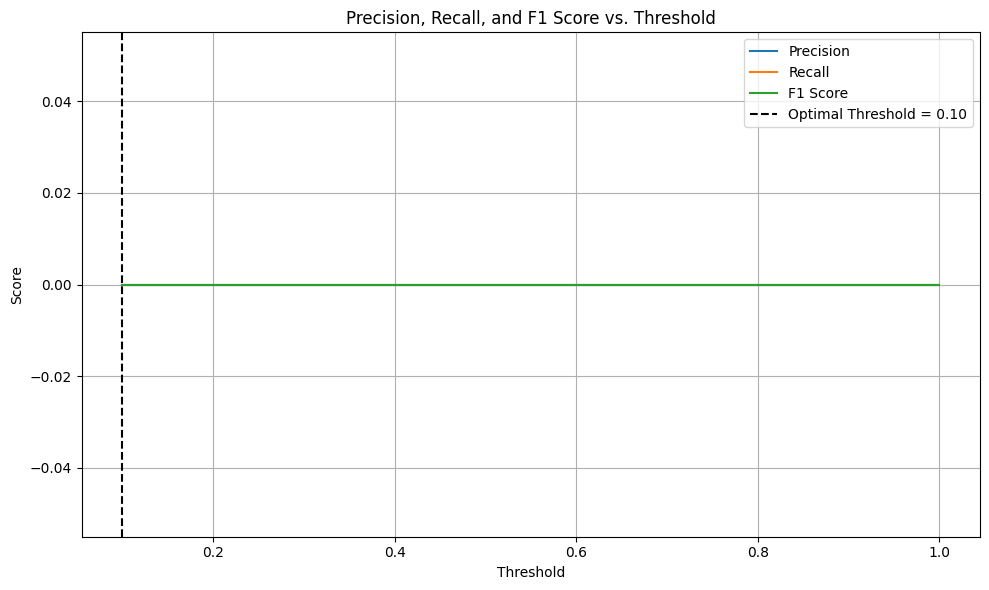

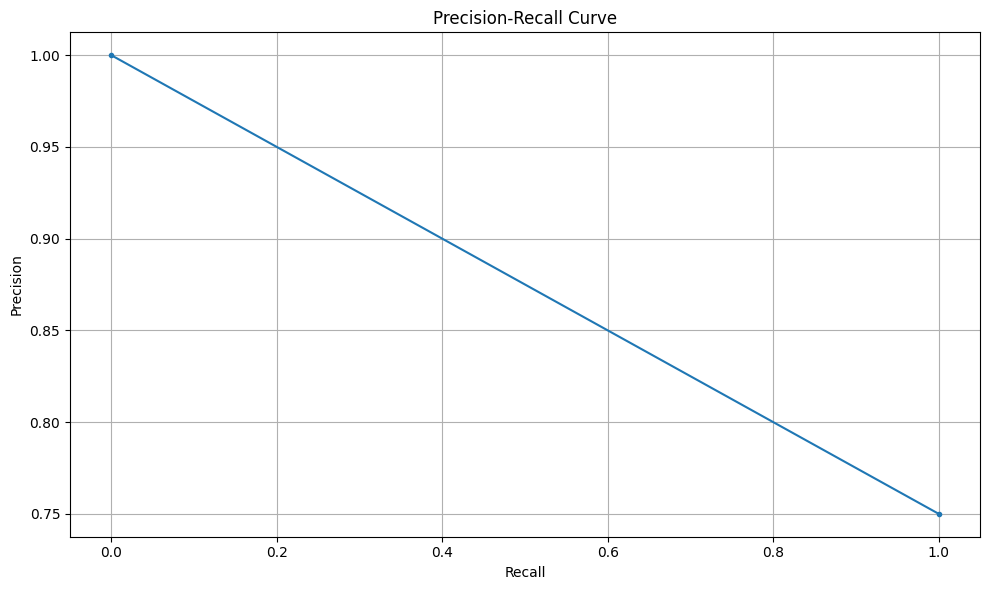


=== Step 3: Algorithm Comparison ===
Comparing matching algorithms...
Evaluating merchant matcher performance...
No test data provided, creating synthetic test data...
Created synthetic test dataset with 32 entries
Category distribution after preprocessing:
Merchant_Category
Unknown    32
Name: count, dtype: int64
Error processing row 0: 'NoneType' object has no attribute 'compute_weighted_score'
Progress: 3.1% (1/32) - Elapsed: 0.0s - Est. remaining: 0.0s
Error processing row 1: 'NoneType' object has no attribute 'compute_weighted_score'
Error processing row 2: 'NoneType' object has no attribute 'compute_weighted_score'
Error processing row 3: 'NoneType' object has no attribute 'compute_weighted_score'
Error processing row 4: 'NoneType' object has no attribute 'compute_weighted_score'
Error processing row 5: 'NoneType' object has no attribute 'compute_weighted_score'
Error processing row 6: 'NoneType' object has no attribute 'compute_weighted_score'
Error processing row 7: 'NoneType'

In [29]:
# Cell 13: Usage Examples and Main Execution

# This cell contains usage examples and demonstrations
merchant_matcher = None
DBA_Merchant_Category = None
RawTransaction_Merchant_Category = None

# Define thresholds for categorization
thresholds = {
    'Exact Match': 0.95,
    'Strong Match': 0.85,
    'Probable Match': 0.75,
    'Possible Match': 0.65,
    'Weak Match': 0.50,
    'No Match': 0.0
}

def main():
    """
    Main function to run the enhanced merchant matching pipeline with proper error handling
    and no duplicate processing.
    """
    start_time = time.time()
    
    # Dictionary to store all results, with proper initialization to avoid undefined variables
    results = {
        'results_df': None,
        'analysis_results': None,
        'threshold_results': None,
        'eval_results': None,
        'batch_results': None
    }
    
    print("\n" + "=" * 80)
    print("Enhanced Merchant Name Matching - Optimized Pipeline".center(80))
    print("=" * 80 + "\n")
    
    try:
        # Check for input file and create if missing
        input_file = "Acronym_extramcc.xlsx"
        import os.path
        if not os.path.isfile(input_file):
            print(f"Input file '{input_file}' not found. Creating sample file...")
            # Create sample file code as in original
            import pandas as pd
            sample_data = {
                'DBAName': ['BOA', 'MCD', 'SBUX', 'AMZN', 'MSFT', 'WMT', 'TGT', 'HD', 'COST', 'GS'],
                'RawTransactionName': ['Bank of America', 'McDonalds', 'Starbucks Coffee', 'Amazon', 
                                      'Microsoft', 'Walmart', 'Target', 'Home Depot', 'Costco', 'Goldman Sachs'],
                'DBA_Merchant_Category': ['Banking', 'Restaurant', 'Restaurant', 'Technology', 'Technology',
                                         'Retail', 'Retail', 'Retail', 'Retail', 'Banking'],
                'RawTransaction_Merchant_Category': ['Banking', 'Restaurant', 'Restaurant', 'Technology', 'Technology',
                                                   'Retail', 'Retail', 'Retail', 'Retail', 'Banking'],
                'Expected_Match': [True, True, True, True, True, True, True, True, True, True]
            }
            test_df = pd.DataFrame(sample_data)
            test_df.to_excel(input_file, index=False)
            print(f"Created sample file '{input_file}' with 10 merchant entries")
        
        # Step 1: Initialize models - do this only ONCE
        print("\nStep 1: Initializing models...")
        bert_embedder = EnhancedBERTEmbedder(model_name='sentence-transformers/all-mpnet-base-v2')
        #merchant_matcher = EnhancedMerchantMatcher(bert_embedder=bert_embedder)
        merchant_matcher = EnhancedMerchantMatcherWithSimilarity(bert_embedder)
        
        # Set common DBANames
        merchant_matcher.common_dbanames = COMMON_DBANameS
        print(f"Enhanced merchant matcher initialized!")
        
        # Step 2: Unified data loading and preprocessing - do this ONCE
        print("\nStep 2: Loading and preprocessing merchant data...")
        merchant_df = load_merchant_data(input_file)
        processed_df = preprocess_merchant_data(merchant_df)
        print(f"Successfully preprocessed {len(processed_df)} merchant records")
        
        # Step 3: Run comprehensive evaluation for insights
        print("\nStep 3: Running comprehensive evaluation...")
        try:
            eval_results = run_comprehensive_evaluation(test_data_path=input_file)
            results['eval_results'] = eval_results

            # Add the new code right here
            if results['eval_results'] and 'has_gold_standard' in results['eval_results']:
                has_gold_standard = results['eval_results']['has_gold_standard']
                if not has_gold_standard:
                    print("Note: Using default threshold values since no gold standard data was available.")
                    
            # Extract and use threshold from evaluation
            if eval_results and 'threshold_optimization' in eval_results:
                threshold_opt = eval_results['threshold_optimization']
                if threshold_opt and 'optimal_threshold' in threshold_opt:
                    optimal_threshold = threshold_opt['optimal_threshold']
                    
                    # Update global thresholds dictionary
                    global thresholds
                    thresholds['Probable Match'] = optimal_threshold
                    thresholds['Strong Match'] = min(1.0, optimal_threshold + 0.1)
                    thresholds['Possible Match'] = max(0.0, optimal_threshold - 0.1)
                    print(f"Updated thresholds based on evaluation: {optimal_threshold:.4f}")
        except Exception as e:
            print(f"Comprehensive evaluation encountered an error: {e}")
            print("Continuing with default thresholds...")
        
        # Step 4: Process data with single unified approach
        print("\nStep 4: Processing merchant data with optimized parameters...")
        output_file = "DBAName_Matching_Results_Optimized.xlsx"
        try:
            # Use the unified processing function
            results_df = process_merchant_data(processed_df, merchant_matcher)
            
            # Add match categories
            results_df = add_match_categories(results_df, thresholds)
            
            # Save results
            results_df.to_excel(output_file, index=False)
            results['results_df'] = results_df
            print(f"Results saved to {output_file}")
            
            # Analyze the results properly
            analysis_results = analyze_merchant_results(results_df)
            results['analysis_results'] = analysis_results
        except Exception as e:
            print(f"Error in processing data: {e}")
        
        # Step 5: Demonstrate batch processing capability (if needed for large files)
        print("\nStep 5: Demonstrating batch processing capability...")
        try:
            batch_results = batch_process_file(
                input_file=input_file,
                output_file="DBAName_Matching_Batched.xlsx",
                batch_size=5,  # Small for demonstration
                use_spark=False  # Only use True if PySpark is properly installed
            )
            results['batch_results'] = batch_results
            
            if isinstance(batch_results, dict) and 'records_processed' in batch_results:
                print(f"Successfully processed {batch_results['records_processed']} records in batches")
        except Exception as e:
            print(f"Batch processing demonstration error: {e}")
        
        # Step 6: Find optimal threshold directly (just to demonstrate the function)
        try:
            print("\nStep 6: Finding optimal threshold directly...")
            threshold_results = find_optimal_threshold(input_file)
            results['threshold_results'] = threshold_results
            
            if threshold_results and 'optimal_threshold' in threshold_results:
                print(f"Optimal threshold found: {threshold_results['optimal_threshold']:.4f}")
        except Exception as e:
            print(f"Error finding optimal threshold: {e}")
        
        # Step 7: Run interactive matcher with limited examples for demonstration
        print("\nStep 7: Interactive merchant matcher demonstration...")
        try:
            example_pairs = [
                ('BOA', 'Bank of America'),
                ('MCD', 'McDonalds'),
                ('AMZN', 'Amazon.com')
            ]
            # Just demonstrate the first example automatically
            DBAName, RawTransactionName = example_pairs[0]
            print(f"Auto-matching example: '{DBAName}' and '{RawTransactionName}'")
            
            # Get score
            score = merchant_matcher.compute_enhanced_score(
                DBAName, 'Banking', RawTransactionName, 'Banking'
            )
            print(f"Match score: {score:.4f}")
            
            # Interactive mode can be enabled with:
            # interactive_merchant_matcher(merchant_matcher, examples=example_pairs, top_n=3)
        except Exception as e:
            print(f"Interactive matcher demonstration error: {e}")
    
    except Exception as e:
        print(f"Major error in merchant matching pipeline: {e}")
    
    # Calculate total execution time
    total_time = time.time() - start_time
    print(f"\nComplete merchant matching pipeline executed in {total_time:.2f} seconds")
    
    # Return safely with all variables properly initialized
    return results

# Make sure to actually call the main function if running as a script
if __name__ == "__main__":
    main()